<a href="https://colab.research.google.com/github/m-lantz/ct_recon_SigPro/blob/main/sigpro_paper_full_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Code to reproduce experiments and figures in the paper:**

"Enhancing signal detectability in learning-based CT reconstruction with a model observer inspired loss function"
*Megan Lantz, Emil Y. Sidky, Ingrid S. Reiser, Xiaochuan Pan, & Gregory Ongie. 2024.*

Code authored by Megan Lantz and Greg Ongie. Feb 14, 2024.

For questions, comments, or bug reports, please contact Megan Lantz at megan.lantz@marquette.edu

# Setup

## Set root path

In [ ]:
PATH = "/content" #colab home directory -- change this if working locally

## Check GPU is enabled

If retraining networks, we suggest using a V100 or A100 GPU colab instance

In [ ]:
import torch

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

## Download Training, Test Sets, Pre-trained Models, and Pre-compiled results

Use gdown utility to download the following folder from Google Drive:
https://drive.google.com/drive/folders/1rASYE2JJJKrHtA3Zjb_lrGRwwgbDnXWZ

This folder contains training and test datasets. It also contains pre-trained networks, and pre-compiled results if some of the training and testing steps below wish to be skipped.

In [ ]:
!pip install gdown
!gdown https://drive.google.com/drive/folders/1rASYE2JJJKrHtA3Zjb_lrGRwwgbDnXWZ -O /content/data --folder

## Define Unet-architecture
This Implementation of a Unet is borrowed from the FastMRI project:

 https://github.com/facebookresearch/fastMRI/blob/main/fastmri/models/unet.py

It has been modified to add an additional residual connection with 1x1 convolution.

In [ ]:
"""
Copyright (c) Facebook, Inc. and its affiliates.
This source code is licensed under the MIT license found in the
LICENSE file in the root directory of this source tree.
"""

# Modified by Greg Ongie to add additional residual connection with 1x1 convolution

import torch
from torch import nn
from torch.nn import functional as F


class ConvBlock(nn.Module):
    """
    A Convolutional Block that consists of two convolution layers each followed by
    instance normalization, LeakyReLU activation and dropout.
    """

    def __init__(self, in_chans, out_chans, drop_prob):
        """
        Args:
            in_chans (int): Number of channels in the input.
            out_chans (int): Number of channels in the output.
            drop_prob (float): Dropout probability.
        """
        super().__init__()

        self.in_chans = in_chans
        self.out_chans = out_chans
        self.drop_prob = drop_prob

        self.layers = nn.Sequential(
            nn.Conv2d(in_chans, out_chans, kernel_size=3, padding=1, bias=False),
            nn.InstanceNorm2d(out_chans),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout2d(drop_prob),
            nn.Conv2d(out_chans, out_chans, kernel_size=3, padding=1, bias=False),
            nn.InstanceNorm2d(out_chans),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout2d(drop_prob)
        )

    def forward(self, input):
        """
        Args:
            input (torch.Tensor): Input tensor of shape [batch_size, self.in_chans, height, width]
        Returns:
            (torch.Tensor): Output tensor of shape [batch_size, self.out_chans, height, width]
        """
        return self.layers(input)


class TransposeConvBlock(nn.Module):
    """
    A Transpose Convolutional Block that consists of one convolution transpose layers followed by
    instance normalization and LeakyReLU activation.
    """

    def __init__(self, in_chans, out_chans):
        """
        Args:
            in_chans (int): Number of channels in the input.
            out_chans (int): Number of channels in the output.
        """
        super().__init__()

        self.in_chans = in_chans
        self.out_chans = out_chans

        self.layers = nn.Sequential(
            nn.ConvTranspose2d(in_chans, out_chans, kernel_size=2, stride=2, bias=False),
            nn.InstanceNorm2d(out_chans),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
        )

    def forward(self, input):
        """
        Args:
            input (torch.Tensor): Input tensor of shape [batch_size, self.in_chans, height, width]
        Returns:
            (torch.Tensor): Output tensor of shape [batch_size, self.out_chans, height, width]
        """
        return self.layers(input)

class ZerosNet(nn.Module):
    def __init__(self):
        super(ZerosNet, self).__init__()

    def forward(self, input):
        return input*0.0 + 0.0

class UnetModel(nn.Module):
    """
    PyTorch implementation of a U-Net model.
    This is based on:
        Olaf Ronneberger, Philipp Fischer, and Thomas Brox. U-net: Convolutional networks
        for biomedical image segmentation. In International Conference on Medical image
        computing and computer-assisted intervention, pages 234–241. Springer, 2015.
    """

    def __init__(self, in_chans, out_chans, chans, num_pool_layers, drop_prob):
        """
        Args:
            in_chans (int): Number of channels in the input to the U-Net model.
            out_chans (int): Number of channels in the output to the U-Net model.
            chans (int): Number of output channels of the first convolution layer.
            num_pool_layers (int): Number of down-sampling and up-sampling layers.
            drop_prob (float): Dropout probability.
        """
        super().__init__()

        self.in_chans = in_chans
        self.out_chans = out_chans
        self.chans = chans
        self.num_pool_layers = num_pool_layers
        self.drop_prob = drop_prob

        self.down_sample_layers = nn.ModuleList([ConvBlock(in_chans, chans, drop_prob)])
        ch = chans
        for i in range(num_pool_layers - 1):
            self.down_sample_layers += [ConvBlock(ch, ch * 2, drop_prob)]
            ch *= 2
        self.conv = ConvBlock(ch, ch * 2, drop_prob)

        self.up_conv = nn.ModuleList()
        self.up_transpose_conv = nn.ModuleList()
        for i in range(num_pool_layers - 1):
            self.up_transpose_conv += [TransposeConvBlock(ch * 2, ch)]
            self.up_conv += [ConvBlock(ch * 2, ch, drop_prob)]
            ch //= 2

        self.up_transpose_conv += [TransposeConvBlock(ch * 2, ch)]
        self.up_conv += [
            nn.Sequential(
                ConvBlock(ch * 2, ch, drop_prob),
                nn.Conv2d(ch, self.out_chans, kernel_size=1, stride=1),
            )]

        self.res = nn.Conv2d(2*in_chans, out_chans, kernel_size=1, padding=0, bias=False)

    def forward(self, input):
        """
        Args:
            input (torch.Tensor): Input tensor of shape [batch_size, self.in_chans, height, width]
        Returns:
            (torch.Tensor): Output tensor of shape [batch_size, self.out_chans, height, width]
        """
        stack = []
        output = input

        # Apply down-sampling layers
        for i, layer in enumerate(self.down_sample_layers):
            output = layer(output)
            stack.append(output)
            output = F.avg_pool2d(output, kernel_size=2, stride=2, padding=0)

        output = self.conv(output)

        # Apply up-sampling layers
        for transpose_conv, conv in zip(self.up_transpose_conv, self.up_conv):
            downsample_layer = stack.pop()
            output = transpose_conv(output)

            # Reflect pad on the right/botton if needed to handle odd input dimensions.
            padding = [0, 0, 0, 0]
            if output.shape[-1] != downsample_layer.shape[-1]:
                padding[1] = 1  # Padding right
            if output.shape[-2] != downsample_layer.shape[-2]:
                padding[3] = 1  # Padding bottom
            if sum(padding) != 0:
                output = F.pad(output, padding, "reflect")

            output = torch.cat([output, downsample_layer], dim=1)
            output = conv(output)

        #concatentate input and output, perform 1x1 convolution (modification by Greg Ongie)
        output = self.res(torch.cat([input,output], dim=1))

        return output

## Define Helper Functions for Training Phase

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def makeGaussian(size, fwhm = 3, center=None):
    """ Make a radial gaussian kernel inside a square image.

    size is the length of a side of the square
    fwhm is full-width-half-maximum (default is 3), which
    can be thought of as an effective radius.

    returns the resulting radial Gaussian kernel
    """

    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]

    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]

    return np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)

class SignalDataset(torch.utils.data.Dataset):
#class for storing signal images
    def __init__(self, sig_only_fbp_image, sig_coordinates, sig_alpha, sig_num=1000):
        self.sig_only_fbp_image = sig_only_fbp_image
        self.sig_coordinates = sig_coordinates.astype(int)
        self.sig_alpha = sig_alpha.astype('float32') #vector of signal magnification factors
        self.img_size = np.array(sig_only_fbp_image.shape[1:])
        self.sig_num = sig_num

    def __len__(self):
        return self.sig_only_fbp_image.shape[0]

    def __getitem__(self,idx):
        '''
        sig_num = the number of signal locations to use during training.
        sig_num = 1 -> use single fixed signal location near center (but not exact center)
        sig_num = 1000 -> use all 1000 signal locations in training
        '''
        if self.sig_num == 1:
          k = 101 #fixed signal location
        else:
          k = np.random.randint(0,self.sig_num) #use random signal

        sig_fbp = self.sig_only_fbp_image[k,np.newaxis,:,:].astype('float32')
        coords = self.sig_coordinates[k,:]+(self.img_size/2).astype(int)
        coords_flip = (coords[1],coords[0])

        window = makeGaussian(self.img_size[0], fwhm = 3, center=coords_flip).astype('float32') #gaussian window centered at signal location
        sig_window = sig_fbp*window #sig_fbp image with streaking artifacts suppressed

        data = {}
        data["sig_template"] = self.sig_alpha[idx]*sig_window #template "shat" used in observer regularizer
        data["sig_fbp"] = self.sig_alpha[idx]*sig_fbp #sig fbp image "s" to be added to noisy fbp image in observer regularizer
        data["sig_coordinates"] = coords
        data["window"] = window
        data["sig_window"]=sig_window

        return data

class ImageDataset(torch.utils.data.Dataset):
#class for storing noisy/clean training pairs
    def __init__(self, bg_image, nosig_fbp_real):
        self.bg_image = bg_image
        self.nosig_fbp_real = nosig_fbp_real
        self.img_size = np.array(bg_image.shape[1:])

    def __len__(self):
        return self.bg_image.shape[0]

    def __getitem__(self,idx):
        bg_image = self.bg_image[idx,np.newaxis,:,:].astype('float32')
        nosig_fbp_real = self.nosig_fbp_real[idx,np.newaxis,:,:].astype('float32')

        data = {}
        data["nosig_image"] = bg_image #ground truth
        data["nosig_real"] = nosig_fbp_real #noisy fbp image (no signal)
        return data

#Define SigPro loss
class SigProLoss(torch.nn.Module):
    def __init__(self,img_size,patch_size,lossfcn,lam,device):
        super(SigProLoss,self).__init__()
        self.device = device
        self.lam = torch.tensor(lam).float().to(device)
        self.img_size = img_size
        self.patch_size = patch_size
        self.lossfcn = lossfcn

    def forward(self,data,net,lossfcn):
        device = self.device

        img_noisy_nosig = data[0]["nosig_real"].to(device)
        img_clean_nosig = data[0]["nosig_image"].to(device)
        img_sigonly = data[1]["sig_template"].to(device)
        img_sigfbp = data[1]["sig_fbp"].to(device)
        img_coordinates_sig = data[1]["sig_coordinates"].to(device)
        img_noisy_sig = img_noisy_nosig+img_sigfbp

        img_recon_sig = net(img_noisy_sig)
        img_recon_nosig = net(img_noisy_nosig)

        mask_sig = torch.zeros_like(img_noisy_sig).bool()

        isize = self.img_size
        ix = int(isize[0]/2)
        iy = int(isize[1]/2)

        psize = self.patch_size
        px = int(psize[0]/2)
        py = int(psize[1]/2)

        for k in range(len(img_noisy_sig)):
            xx,yy = img_coordinates_sig[k,:]
            mask_sig[k,:,(xx-px):(xx+px),(yy-py):(yy+py)] = True

        img_small_sig = torch.reshape(img_recon_sig[mask_sig],(-1,psize[0],psize[1]))
        img_small_nosig = torch.reshape(img_recon_nosig[mask_sig],(-1,psize[0],psize[1]))
        img_small_sigonly = torch.reshape(img_sigonly[mask_sig],(-1,psize[0],psize[1]))

        # Compute loss using passed in lossfcn (with respect to nosig images only)
        loss1 = self.lossfcn(img_recon_nosig,img_clean_nosig)

        # Compute observer Loss
        g1bar = torch.dot(torch.flatten(img_small_sig),torch.flatten(img_small_sigonly))
        g0bar = torch.dot(torch.flatten(img_small_nosig),torch.flatten(img_small_sigonly)) #this doesn't make sense...
        loss2 = g1bar-g0bar

        loss = loss1-self.lam*loss2

        return loss,loss1,loss2


def train_epoch(train_images_loader, train_signals_loader, net, lossfcn, obsloss, optimizer, ep, device):
  '''
  takes in dataset of noisy training images and dataset of signals,
  trained denoising network, loss function, obsloss function definition,
  optimizer, and device
  runs a single training epoch for the passed in net
  '''

  epoch=ep
  running_loss = 0.0
  running_loss1 = 0.0
  running_loss2 = 0.0
  for i, data in enumerate(zip(train_images_loader,train_signals_loader)):
      # compute loss + gradients
      optimizer.zero_grad()
      loss,loss1,loss2 = obsloss(data, net, lossfcn)

      loss.backward()
      optimizer.step()

      # print statistics
      running_loss += float(loss)
      running_loss1 += float(loss1)
      running_loss2 += float(loss2)

      if i % 10 == 9:    # print every 10 mini-batches
          print('[%d, %5d] total loss: %.8f, MSE loss: %.8f, SigPro loss: -%.8f' %
                  (epoch + 1, i + 1, running_loss / 10, running_loss1 / 10, running_loss2 / 10))
          running_loss = 0.0
          running_loss1 = 0.0
          running_loss2 = 0.0


def train_net(net,options,sig_num=1000):
  '''
  takes in pre-trained network and the number of signal locations to
  use for training
  sig_num = 1 -> fixed signal location near center
  sig_num = 1000 -> full set of 1000 signal locations (randomized)
  retrains net for options['epochs'] epochs using observer loss regularization
  '''

  #load training data into numpy arrays
  DATADIR = PATH + "/data/realdataFBPsmoothObj_nph4e10/"
  bg_image = np.load(DATADIR+"bg_image_grp1.npy", mmap_mode = "r") #ground truth image, signal absent
  ntrain = len(bg_image)
  nosig_fbp_image  = np.load(DATADIR+"nosig_128views_fbp_image_grp1.npy", mmap_mode = "r")  #fbp image, signal absent
  nosig_fbp_real  = np.load(DATADIR+"nosig_128views_fbp_real_grp1.npy", mmap_mode = "r")  #noisy fbp image, signal absent
  sig_only_fbp_image  = np.load(DATADIR+"sig_only_fbp_grp1.npy", mmap_mode = "r") #signal only fbp image
  sig_coordinates = np.load(DATADIR+"coords_grp1.npy") #signal location in image
  sig_alpha = 2*np.ones((ntrain,)) #signal ampltude vector -- increase saved signals by factor of 2 for all images

  train_images_dataset = ImageDataset(bg_image, nosig_fbp_real)
  train_signals_dataset = SignalDataset(sig_only_fbp_image, sig_coordinates, sig_alpha, sig_num=sig_num)

  bs = options['batch_size'] #batchsize (no. of sig absent/sig present pairs to use in calculating SigPro loss)
  train_images_loader = torch.utils.data.DataLoader(train_images_dataset, batch_size=bs, shuffle=True, num_workers=2)
  train_signals_loader = torch.utils.data.DataLoader(train_signals_dataset, batch_size=bs, shuffle=False, num_workers=2)

  #Alter residual layer weights prior to retraining. This modifies the network
  #so that it outputs a fraction of the noisy fbp image. This seemed to help
  #push the network away from its initialization and improve in terms of the observer loss.
  alpha = options["alpha"]
  net.res.weight.data[0][0] = alpha+(1.0-alpha)*net.res.weight.data[0][0]
  net.res.weight.data[0][1] = (1.0-alpha)*net.res.weight.data[0][1]
  net.res.requires_grad_(False); #freeze weights on residual layer during training

  img_size = (512,512)
  patch_size = (10,10)
  lossfcn = nn.MSELoss()
  lam = options["lam"]

  # matched filter approach (inner product with signal)
  obsloss = SigProLoss(img_size,patch_size,lossfcn,lam,device)

  optimizer = torch.optim.Adam(net.parameters(), lr=options['init_lr'])

  for epoch in range(options["epochs"]):
    train_epoch(train_images_loader, train_signals_loader, net, lossfcn, obsloss, optimizer, epoch, device)

def loadBaseNet():
  '''
  returns the pre-trained Unet with weights for denoiser trained with MSE loss only
  (same training set, 10 epochs of Adam using lr=0.001, batch_size=2)
  '''
  net = UnetModel(in_chans=1, out_chans=1, num_pool_layers=4, drop_prob=0.0, chans=32)
  net = net.to(device)

  # load pre-trained network weights
  NETNAME = PATH+"/data/saved_models/realdataFBPsmoothObj_nph4e10-pure-denoiser-net.pth"
  net.load_state_dict(torch.load(NETNAME))
  net.eval();

  return net

## Define Helper Functions for Testing Phase

In [ ]:
#Define Laguerre-Gauss Channels for CHO

from scipy.special import laguerre

#define a single Laguerre-Gauss Channel
def u(r, a, j):
#j = Degree of polynomial, jp = Index
    return (np.sqrt(2.)/a)*np.exp((-np.pi*r**2.)/a**2.)*laguerre(j)((2.*np.pi*r**2.)/a**2.)

def getchannels(a = 0.5, pc = 1, lgc = 10, sz = 128):
  xar = np.arange(-1. + 1/sz, 1., 2/sz)[:,np.newaxis]*np.ones(sz)
  yar = np.ones(sz)[:,np.newaxis]*np.arange(-1. + 1/sz, 1., 2/sz)
  rar = np.sqrt(xar**2 + yar**2)

  #define channels
  r = rar
  # a = 0.5   #width of the LG channels
  uars = []
  uti = np.zeros([sz,sz])
  #collect the pixel channels first
  for i in range(int(sz/2)-pc,int(sz/2)+pc):
    for j in range(int(sz/2)-pc,int(sz/2)+pc):
        uti.fill(0.)
        uti[i,j] = 1.
        uars.append(uti*1.)
  #collect the Laguerre Gauss channels next
  for d in range(0,lgc):
      b = np.arange(0,d+1)
      uar = u(r, a, d)
      uars.append(1*uar)
  uars = np.array(uars)

  nchan = len(uars)
  # print(nchan)

  # normalize the channels
  normchans = []
  for i in range(nchan):
    newchan = uars[i]*1.
    for nchn in normchans:
        newchan -= ( (newchan*nchn).sum() * nchn)
    newchan /= np.sqrt( (newchan**2).sum() )
    normchans.append(newchan)
  normchans = np.array(normchans)

  uars = normchans*1.
  return uars

#compute empirical AUC of CHO via 2-AFC experiment
def computehcho_centered(uars, sigimages2, bkgimages2, bkgtruth):
  nchan = len(uars)

  sigimages = sigimages2.copy()
  bkgimages = bkgimages2.copy()

  sigimages -= bkgtruth
  bkgimages -= bkgtruth

  nreal = len(sigimages)
  dim = np.shape(sigimages)[1:]

  #extract 128x128 ROI from 512x512 image
  sigreal = sigimages[:,192:320,192:320]
  bkgreal = bkgimages[:,192:320,192:320]

  trainsig = sigreal[:int(nreal/2)]*1.
  trainbkg = bkgreal[:int(nreal/2)]*1.
  testsig = sigreal[int(nreal/2):]*1.
  testbkg = bkgreal[int(nreal/2):]*1.

  meansig =trainsig.sum(axis=0)/(nreal/2.)
  meanbkg =trainbkg.sum(axis=0)/(nreal/2.)

  meandiff = meansig-meanbkg
  covar = np.zeros([nchan,nchan])
  #use both sig and bkg realizations to estimate covariance
  for i in range(int(nreal/2)):
    ccs = ((uars*(trainsig[i]-meansig)).sum(axis=2)).sum(axis=1)
    covar += np.outer(ccs,ccs)
  for i in range(int(nreal/2)):
    ccs = ((uars*(trainbkg[i]-meanbkg)).sum(axis=2)).sum(axis=1)
    covar += np.outer(ccs,ccs)
  covar/=(nreal-1.)

  cc = ((uars*meandiff).sum(axis=2)).sum(axis=1)
  #compute channelized template
  wcc = np.dot(np.linalg.inv(covar),cc)

  #convert the Hotelling template back to an image
  w = meandiff*0.
  for i in range(nchan):
    w += wcc[i]*uars[i]

  pcscore = 0.
  for i in range(int(nreal/2)):
    sc1 = (testbkg[i]*w).sum()
    for j in range(int(nreal/2)):
        sc2 = (testsig[j]*w).sum()
        if sc2>sc1:
          pcscore += 1.
        if sc2==sc1:
          pcscore += 0.5
  hcho_auc = pcscore/((nreal/2.)**2.)
  # print("trained HO auc: ",auc)

  return w, hcho_auc, wcc

#AUC calculation for fixed template observers
def sigauc3(sigimages2, bkgimages2, bkgtruth, sigonly2, roi):
    sigimages = sigimages2 - bkgtruth
    bkgimages = bkgimages2 - bkgtruth

    nreal = len(sigimages)
    i1 = 256 - int(roi[0] / 2)
    i2 = 256 + int(roi[1] / 2) + 1

    testsig = sigimages[:, i1:i2, i1:i2]
    testbkg = bkgimages[:, i1:i2, i1:i2]
    w = sigonly2[i1:i2, i1:i2]

    sc1 = np.sum(testbkg * w,(1,2)) #signal absent
    sc2 = np.sum(testsig * w,(1,2)) #signal present

    sc2 = sc2.reshape((nreal,1))
    tp_mat = np.matlib.repmat(sc2,1, 1000)
    ta_mat = np.matlib.repmat(sc1, 1000, 1)

    pcscore = np.sum(tp_mat > ta_mat) + 0.5 * np.sum(tp_mat == ta_mat)
    sig_auc = (pcscore) / ((nreal) ** 2.)

    return pcscore, sig_auc

##### testing with Hybrid LG+pixel CHO

def test_net(net):
  '''
  compute MSE and AUC on fixed signal test set, given a trained denoising network
  '''
  DATADIR = PATH + "/data/realdataFixedSigStructBGsmoothObj_nph4e10/"
  t_nosig_real  = np.load(DATADIR+"nosig_128views_fbp_real_grp1.npy",mmap_mode='r')  #noisy image, signal absent
  t_sig_real  = np.load(DATADIR+"sig_128views_fbp_real_grp1.npy",mmap_mode='r')      #noisy image, signal present
  bg_image = np.load(DATADIR+"bg_image.npy") #background image (signal absent)

  #denoise test set images
  nreal = len(t_nosig_real)
  t_sig_denoised = np.zeros((nreal,512,512),dtype='float32')
  t_nosig_denoised = np.zeros((nreal,512,512),dtype='float32')

  for k in range(nreal):
    t_sig = torch.from_numpy(t_sig_real[k,np.newaxis,:,:]).detach().float().to(device)
    t_nosig = torch.from_numpy(t_nosig_real[k,np.newaxis,:,:]).detach().float().to(device)
    t_sig_denoised[k,:,:] = net(t_sig[np.newaxis,:,:,:]).detach().cpu().numpy()[0,0,:,:]
    t_nosig_denoised[k,:,:] = net(t_nosig[np.newaxis,:,:,:]).detach().cpu().numpy()[0,0,:,:]

  # compute test MSE
  se_arr = np.sum(np.square(t_nosig_denoised - bg_image),axis=(1,2))/(512**2)
  se_arr = np.append(se_arr,np.sum(np.square(t_sig_denoised - bg_image),axis=(1,2))/(512**2))
  mse = np.mean(se_arr)
  print('test denoised MSE: %.8f' % mse)

  # compute test AUC
  uars = getchannels(a = 0.15, pc = 1, lgc = 10, sz = 128)
  w, auc, wcc = computehcho_centered(uars, t_sig_denoised, t_nosig_denoised, bg_image)
  print('test denoised AUC: %.4f' % auc)

  return mse, auc

def test_add_back(net,alpha):
  '''
  compute MSE and AUC on fixed signal test set, given a trained denoising network
  '''
  DATADIR = PATH + "/data/realdataFixedSigStructBGsmoothObj_nph4e10/"
  t_nosig_real  = np.load(DATADIR+"nosig_128views_fbp_real_grp1.npy",mmap_mode='r')  #noisy image, signal absent
  t_sig_real  = np.load(DATADIR+"sig_128views_fbp_real_grp1.npy",mmap_mode='r')      #noisy image, signal present
  bg_image = np.load(DATADIR+"bg_image.npy") #background image (signal absent)

  #denoise test set images
  nreal = len(t_nosig_real)
  t_sig_denoised = np.zeros((nreal,512,512),dtype='float32')
  t_nosig_denoised = np.zeros((nreal,512,512),dtype='float32')

  for k in range(nreal):
    t_sig = torch.from_numpy(t_sig_real[k,np.newaxis,:,:]).detach().float().to(device)
    t_nosig = torch.from_numpy(t_nosig_real[k,np.newaxis,:,:]).detach().float().to(device)
    t_sig_denoised[k,:,:] = net(t_sig[np.newaxis,:,:,:]).detach().cpu().numpy()[0,0,:,:]
    t_nosig_denoised[k,:,:] = net(t_nosig[np.newaxis,:,:,:]).detach().cpu().numpy()[0,0,:,:]

  t_sig_denoised = (1-alpha)*t_sig_denoised + alpha*t_sig_real
  t_nosig_denoised = (1-alpha)*t_nosig_denoised + alpha*t_nosig_real

  # compute test MSE
  se_arr = np.sum(np.square(t_nosig_denoised - bg_image),axis=(1,2))/(512**2)
  se_arr = np.append(se_arr,np.sum(np.square(t_sig_denoised - bg_image),axis=(1,2))/(512**2))
  mse = np.mean(se_arr)
  print('test denoised MSE: %.8f' % mse)

  # compute test AUC
  uars = getchannels(a = 0.15, pc = 1, lgc = 10, sz = 128)
  w, auc, wcc = computehcho_centered(uars, t_sig_denoised, t_nosig_denoised, bg_image)
  print('test denoised AUC: %.4f' % auc)

  return mse, auc

def test_net_bootstrap(net,rep=100):
  '''
  compute MSE and AUC on fixed signal test set, given a trained denoising network
  '''
  DATADIR = PATH + "/data/realdataFixedSigStructBGsmoothObj_nph4e10/"
  t_nosig_real  = np.load(DATADIR+"nosig_128views_fbp_real_grp1.npy",mmap_mode='r')  #noisy image, signal absent
  t_sig_real  = np.load(DATADIR+"sig_128views_fbp_real_grp1.npy",mmap_mode='r')      #noisy image, signal present
  bg_image = np.load(DATADIR+"bg_image.npy") #background image (signal absent)

  #denoise test set images
  nreal = len(t_nosig_real)
  t_sig_denoised = np.zeros((nreal,512,512),dtype='float32')
  t_nosig_denoised = np.zeros((nreal,512,512),dtype='float32')
  bootstrap_mse = np.zeros(rep)
  bootstrap_auc = np.zeros(rep)

  with torch.no_grad():
    k=0
    while k < nreal:
      k_end = k+10
      t_sig = torch.from_numpy(t_sig_real[k:k_end,:,:]).float().to(device)
      t_nosig = torch.from_numpy(t_nosig_real[k:k_end,:,:]).float().to(device)
      t_sig_denoised[k:k_end,:,:] = net(t_sig[:,np.newaxis,:,:]).detach().cpu().numpy()[0,0,:,:]
      t_nosig_denoised[k:k_end,:,:] = net(t_nosig[:,np.newaxis,:,:]).detach().cpu().numpy()[0,0,:,:]
      k=k_end

  for r in range(rep):
    select_i = np.random.choice(1000,1000,replace=True)
    select_t_sig_denoised = t_sig_denoised[select_i,:,:]
    select_t_nosig_denoised = t_nosig_denoised[select_i,:,:]

    # compute test MSE
    se_arr = np.sum(np.square(select_t_nosig_denoised - bg_image),axis=(1,2))/(512**2)
    se_arr = np.append(se_arr,np.sum(np.square(select_t_sig_denoised - bg_image),axis=(1,2))/(512**2))
    mse = np.mean(se_arr)
    bootstrap_mse[r]=mse
    #print('denoised MSE: %.8f' % mse)

    # compute test AUC
    uars = getchannels(a = 0.15, pc = 1, lgc = 10, sz = 128)
    w, auc, wcc = computehcho_centered(uars, select_t_sig_denoised, select_t_nosig_denoised, bg_image)
    bootstrap_auc[r]=auc
    #print('denoised AUC: %.8f' % auc)

  mean_mse = np.mean(bootstrap_mse)
  std_mse = np.std(bootstrap_mse)

  mean_auc = np.mean(bootstrap_auc)
  std_auc = np.std(bootstrap_auc)

  return mean_mse, std_mse, mean_auc, std_auc

def test_add_back_bootstrap(net, alpha, rep=100):
  '''
  compute MSE and AUC on fixed signal test set, given a trained denoising network
  alpha = fraction of input to add to output
  '''
  DATADIR = PATH + "/data/realdataFixedSigStructBGsmoothObj_nph4e10/"
  t_nosig_real  = np.load(DATADIR+"nosig_128views_fbp_real_grp1.npy",mmap_mode='r')  #noisy image, signal absent
  t_sig_real  = np.load(DATADIR+"sig_128views_fbp_real_grp1.npy",mmap_mode='r')      #noisy image, signal present
  bg_image = np.load(DATADIR+"bg_image.npy") #background image (signal absent)

  #denoise test set images
  nreal = len(t_nosig_real)
  t_sig_denoised = np.zeros((nreal,512,512),dtype='float32')
  t_nosig_denoised = np.zeros((nreal,512,512),dtype='float32')
  bootstrap_mse = np.zeros(rep)
  bootstrap_auc = np.zeros(rep)

  with torch.no_grad():
    k=0
    while k < nreal:
      k_end = k+10
      t_sig = torch.from_numpy(t_sig_real[k:k_end,:,:]).float().to(device)
      t_nosig = torch.from_numpy(t_nosig_real[k:k_end,:,:]).float().to(device)

      t_sig_denoised[k:k_end,:,:] = net(t_sig[:,np.newaxis,:,:]).detach().cpu().numpy()[0,0,:,:]
      t_nosig_denoised[k:k_end,:,:] = net(t_nosig[:,np.newaxis,:,:]).detach().cpu().numpy()[0,0,:,:]

      t_sig_denoised[k:k_end,:,:] = (1.0-alpha)*t_sig_denoised[k:k_end,:,:] + alpha*t_sig_real[k:k_end,:,:]
      t_nosig_denoised[k:k_end,:,:] =(1.0-alpha)*t_nosig_denoised[k:k_end,:,:] + alpha*t_nosig_real[k:k_end, :,:]
      k = k_end

  for r in range(rep):
    select_i = np.random.choice(1000,1000,replace=True)
    select_t_sig_denoised = t_sig_denoised[select_i,:,:]
    select_t_nosig_denoised = t_nosig_denoised[select_i,:,:]

    # compute test MSE
    se_arr = np.sum(np.square(select_t_nosig_denoised - bg_image),axis=(1,2))/(512**2)
    se_arr = np.append(se_arr,np.sum(np.square(select_t_sig_denoised - bg_image),axis=(1,2))/(512**2))
    mse = np.mean(se_arr)
    bootstrap_mse[r]=mse
    #print('denoised MSE: %.8f' % mse)

    # compute test AUC
    uars = getchannels(a = 0.15, pc = 1, lgc = 10, sz = 128)
    w, auc, wcc = computehcho_centered(uars, select_t_sig_denoised, select_t_nosig_denoised, bg_image)
    bootstrap_auc[r]=auc
    #print('denoised AUC: %.8f' % auc)

  mean_mse = np.mean(bootstrap_mse)
  std_mse = np.std(bootstrap_mse)

  mean_auc = np.mean(bootstrap_auc)
  std_auc = np.std(bootstrap_auc)

  return mean_mse, std_mse, mean_auc, std_auc

##### testing with signal-Laplacian observer

from scipy import ndimage
def test_net_lap(net):
  '''
  compute MSE and AUC on fixed signal test set, given a trained denoising network using sig-Laplacian observer
  '''

  window = makeGaussian(512, fwhm = 3, center=[256,256]).astype('float32') #gaussian window centered at signal location
  sig_only = sigonly*window

  DATADIR = PATH + "/data/realdataFixedSigStructBGsmoothObj_nph4e10/"
  t_nosig_real  = np.load(DATADIR+"nosig_128views_fbp_real_grp1.npy",mmap_mode='r')  #noisy image, signal absent
  t_sig_real  = np.load(DATADIR+"sig_128views_fbp_real_grp1.npy",mmap_mode='r')      #noisy image, signal present
  bg_image = np.load(DATADIR+"bg_image.npy") #background image (signal absent)
  sigfbp = np.load(DATADIR+"sig_128views_fbp_image.npy")
  bkgfbp = np.load(DATADIR+"nosig_128views_fbp_image.npy")
  sigonly = sigfbp-bkgfbp
  lap_sigonly = -ndimage.laplace(sigonly) #lapacian filered template

  #denoise test set images
  nreal = len(t_nosig_real)
  t_sig_denoised = np.zeros((nreal,512,512),dtype='float32')
  t_nosig_denoised = np.zeros((nreal,512,512),dtype='float32')

  with torch.no_grad():
    k=0
    while k < nreal:
      k_end = k+10
      t_sig = torch.from_numpy(t_sig_real[k:k_end,:,:]).float().to(device)
      t_nosig = torch.from_numpy(t_nosig_real[k:k_end,:,:]).float().to(device)
      t_sig_denoised[k:k_end,:,:] = net(t_sig[:,np.newaxis,:,:]).detach().cpu().numpy()[0,0,:,:]
      t_nosig_denoised[k:k_end,:,:] = net(t_nosig[:,np.newaxis,:,:]).detach().cpu().numpy()[0,0,:,:]
      k=k_end

  # compute test MSE
  se_arr = np.sum(np.square(t_nosig_denoised - bg_image),axis=(1,2))/(512**2)
  se_arr = np.append(se_arr,np.sum(np.square(t_sig_denoised - bg_image),axis=(1,2))/(512**2))
  mse = np.mean(se_arr)
  print('test denoised MSE: %.8f' % mse)


  # compute test AUC using signal channel
  roi = (10,10)
  pcscore, lap_sig_auc = sigauc3(t_sig_denoised, t_nosig_denoised, bg_image, lap_sigonly, roi)
  print('Laplacian Sig Channel AUC : %.4f' % lap_sig_auc)

  return mse, lap_sig_auc

def test_net_bootstrap_lap(net,rep=100):
  '''
  compute MSE and AUC on fixed signal test set, given a trained denoising network
  '''

  DATADIR = PATH + "/data/realdataFixedSigStructBGsmoothObj_nph4e10/"
  t_nosig_real  = np.load(DATADIR+"nosig_128views_fbp_real_grp1.npy",mmap_mode='r')  #noisy image, signal absent
  t_sig_real  = np.load(DATADIR+"sig_128views_fbp_real_grp1.npy",mmap_mode='r')      #noisy image, signal present
  bg_image = np.load(DATADIR+"bg_image.npy") #background image (signal absent)
  sigfbp = np.load(DATADIR+"sig_128views_fbp_image.npy")
  bkgfbp = np.load(DATADIR+"nosig_128views_fbp_image.npy")
  sigonly = sigfbp-bkgfbp
  lap_sigonly = -ndimage.laplace(sigonly) #lapacian filered template

  #denoise test set images
  nreal = len(t_nosig_real)
  t_sig_denoised = np.zeros((nreal,512,512),dtype='float32')
  t_nosig_denoised = np.zeros((nreal,512,512),dtype='float32')
  bootstrap_mse = np.zeros(rep)
  bootstrap_auc = np.zeros(rep)
  bootstrap_auc_lap = np.zeros(rep)

  with torch.no_grad():
    k=0
    while k < nreal:
      k_end = k+10
      t_sig = torch.from_numpy(t_sig_real[k:k_end,:,:]).float().to(device)
      t_nosig = torch.from_numpy(t_nosig_real[k:k_end,:,:]).float().to(device)
      t_sig_denoised[k:k_end,:,:] = net(t_sig[:,np.newaxis,:,:]).detach().cpu().numpy()[0,0,:,:]
      t_nosig_denoised[k:k_end,:,:] = net(t_nosig[:,np.newaxis,:,:]).detach().cpu().numpy()[0,0,:,:]
      k=k_end

  for r in range(rep):
    select_i = np.random.choice(1000,1000,replace=True)
    select_t_sig_denoised = t_sig_denoised[select_i,:,:]
    select_t_nosig_denoised = t_nosig_denoised[select_i,:,:]

    # compute test MSE
    se_arr = np.sum(np.square(select_t_nosig_denoised - bg_image),axis=(1,2))/(512**2)
    se_arr = np.append(se_arr,np.sum(np.square(select_t_sig_denoised - bg_image),axis=(1,2))/(512**2))
    mse = np.mean(se_arr)
    bootstrap_mse[r]=mse
    #print('denoised MSE: %.8f' % mse)

    roi = (10,10)
    pc, lap_sig_auc = sigauc3(select_t_sig_denoised, select_t_nosig_denoised, bg_image, lap_sigonly, roi)
    #print('Laplacian Sig Channel AUC : %.4f' % lap_sig_auc)

    bootstrap_auc_lap[r]=lap_sig_auc

  mean_mse = np.mean(bootstrap_mse)
  std_mse = np.std(bootstrap_mse)

  mean_auc_lap = np.mean(bootstrap_auc_lap)
  std_auc_lap = np.std(bootstrap_auc_lap)

  return mean_mse, std_mse,  mean_auc_lap, std_auc_lap


def test_add_back_bootstrap_lap(net, alpha, rep=100):
  '''
  compute MSE and AUC on fixed signal test set, given a trained denoising network using sig-Laplacian observer
  '''

  DATADIR = PATH + "/data/realdataFixedSigStructBGsmoothObj_nph4e10/"
  t_nosig_real  = np.load(DATADIR+"nosig_128views_fbp_real_grp1.npy",mmap_mode='r')  #noisy image, signal absent
  t_sig_real  = np.load(DATADIR+"sig_128views_fbp_real_grp1.npy",mmap_mode='r')      #noisy image, signal present
  bg_image = np.load(DATADIR+"bg_image.npy") #background image (signal absent)
  sigfbp = np.load(DATADIR+"sig_128views_fbp_image.npy")
  bkgfbp = np.load(DATADIR+"nosig_128views_fbp_image.npy")
  sigonly = sigfbp-bkgfbp
  lap_sigonly = -ndimage.laplace(sigonly) #lapacian filered template


  #denoise test set images
  nreal = len(t_nosig_real)
  t_sig_denoised = np.zeros((nreal,512,512),dtype='float32')
  t_nosig_denoised = np.zeros((nreal,512,512),dtype='float32')
  bootstrap_mse = np.zeros(rep)
  bootstrap_auc = np.zeros(rep)

  with torch.no_grad():
    k=0
    while k < nreal:
      k_end = k+10
      t_sig = torch.from_numpy(t_sig_real[k:k_end,np.newaxis,:,:]).float().to(device)
      t_nosig = torch.from_numpy(t_nosig_real[k:k_end,np.newaxis,:,:]).float().to(device)

      t_sig_denoised[k:k_end,:,:] = net(t_sig[:,:,:]).detach().cpu().numpy()[0,0,:,:]
      t_nosig_denoised[k:k_end,:,:] = net(t_nosig[:,:,:]).detach().cpu().numpy()[0,0,:,:]

      t_sig_denoised[k:k_end,:,:] = (1.0-alpha)*t_sig_denoised[k:k_end,:,:] + alpha*t_sig_real[k:k_end,:,:]
      t_nosig_denoised[k:k_end,:,:] =(1.0-alpha)*t_nosig_denoised[k:k_end,:,:] + alpha*t_nosig_real[k:k_end, :,:]
      k = k_end

  for r in range(rep):
    select_i = np.random.choice(1000,1000,replace=True)
    select_t_sig_denoised = t_sig_denoised[select_i,:,:]
    select_t_nosig_denoised = t_nosig_denoised[select_i,:,:]

    # compute test MSE
    se_arr = np.sum(np.square(select_t_nosig_denoised - bg_image),axis=(1,2))/(512**2)
    se_arr = np.append(se_arr,np.sum(np.square(select_t_sig_denoised - bg_image),axis=(1,2))/(512**2))
    mse = np.mean(se_arr)
    bootstrap_mse[r]=mse
    #print('denoised MSE: %.8f' % mse)

    roi = (10, 10)
    pc, lap_sig_auc = sigauc3(select_t_sig_denoised, select_t_nosig_denoised, bg_image, lap_sigonly, roi)
    #print('Laplacian Sig Channel AUC : %.4f' % lap_sig_auc)

    bootstrap_auc[r]=lap_sig_auc

  mean_mse = np.mean(bootstrap_mse)
  std_mse = np.std(bootstrap_mse)

  mean_auc_lap = np.mean(bootstrap_auc)
  std_auc_lap = np.std(bootstrap_auc)

  return mean_mse, std_mse, mean_auc_lap, std_auc_lap


def denoise_single_test(net, show_images=True, save_image=False, fname=None):
  '''
  applies the passed in unet model to a single (preset) test image
  displays the results if show_images is True (default)
  saves the reconstructed/output test image if save_image is True
  and fname is specified

  returns the fbp MSE, the denoised MSE, and denoised image
  '''
  DATADIR = PATH + "/data/singledata512smoothObj_nph4e10/"

  noisy_image = np.load(DATADIR+"fbp_128view_noisy.npy")
  truth_image  = np.load(DATADIR+"fbp_1024view_noiseless.npy")

  t_noisy_image = torch.from_numpy(noisy_image).float().to(device)
  denoised_image = net(t_noisy_image[np.newaxis,np.newaxis,:,:]).detach().cpu().numpy()[0,0,:,:]

  # compute MSE
  f_mse = np.sum(np.square(noisy_image - truth_image))/(512**2)
  print('fbp MSE:      %.8f' % f_mse)

  d_mse = np.sum(np.square(denoised_image - truth_image))/(512**2)
  print('denoised MSE: %.8f' % d_mse)

  test_noisy = noisy_image[240:370,10:200]
  test_recon = denoised_image[240:370,10:200]
  test_clean = truth_image[240:370,10:200]

  vmax = 0.253
  vmin = 0.174
  if show_images:
    fig, ax = plt.subplots(2, 2, figsize=(15,10))
    ax[0,0].imshow(test_noisy,vmin=vmin,vmax=vmax, cmap = "gray", interpolation='nearest')
    ax[0,0].set_title("noisy fbp image")
    ax[0,1].imshow(test_recon,vmin=vmin,vmax=vmax, cmap = "gray", interpolation='nearest')
    ax[0,1].set_title("recon")
    ax[1,0].imshow(test_clean,vmin=vmin,vmax=vmax, cmap = "gray", interpolation='nearest')
    ax[1,0].set_title("ground truth")
    im = ax[1,1].imshow(np.abs(test_clean-test_recon), interpolation='nearest')
    ax[1,1].set_title("abs(recon-truth)")

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.82, 0.17, 0.01, 0.25])
    fig.colorbar(im, cax=cbar_ax);

  else:
    fig = plt.figure()
    plt.imshow(test_recon,vmin=vmin,vmax=vmax, cmap = "gray", interpolation='nearest')

  if save_image:
    np.save(fname, denoised_image)
    #fname=f"{PATH}/{fname}.png"
    #plt.savefig(fname)
    #plt.close()

  return f_mse, d_mse, test_recon

def denoise_single_test_add_back(net, alpha, show_images=True, save_image=False, fname=None):
  '''
  applies the passed in unet model to a single (preset) test image
  uses the denoised image + alpha*noisy image to generate a reconstructed image
  displays the results if show_images is True (default)
  returns the fbp MSE, the denoised MSE and denoised image
  '''
  DATADIR = "/data/singledata512smoothObj_nph4e10/"

  noisy_image = np.load(PATH+DATADIR+"fbp_128view_noisy.npy")
  truth_image  = np.load(PATH+DATADIR+"fbp_1024view_noiseless.npy")

  t_noisy_image = torch.from_numpy(noisy_image).float().to(device)
  denoised_image = net(t_noisy_image[np.newaxis,np.newaxis,:,:]).detach().cpu().numpy()[0,0,:,:]
  t_denoised_image = torch.from_numpy(denoised_image).float().to(device)
  denoised_image = (1.0-alpha)*t_denoised_image + alpha*t_noisy_image
  denoised_image = denoised_image.detach().cpu().numpy()

  # compute MSE
  f_mse = np.sum(np.square(noisy_image - truth_image))/(512**2)
  print('fbp MSE:      %.8f' % f_mse)

  d_mse = np.sum(np.square(denoised_image - truth_image))/(512**2)
  print('denoised MSE: %.8f' % d_mse)

  test_noisy = noisy_image[240:370,10:200]
  test_recon = denoised_image[240:370,10:200]
  test_clean = truth_image[240:370,10:200]

  vmax = 0.253
  vmin = 0.174
  if show_images:
    fig, ax = plt.subplots(2, 2, figsize=(15,10))
    ax[0,0].imshow(test_noisy,vmin=vmin,vmax=vmax, cmap = "gray", interpolation='nearest')
    ax[0,0].set_title("noisy fbp image")
    ax[0,1].imshow(test_recon,vmin=vmin,vmax=vmax, cmap = "gray", interpolation='nearest')
    ax[0,1].set_title("recon")
    ax[1,0].imshow(test_clean,vmin=vmin,vmax=vmax, cmap = "gray", interpolation='nearest')
    ax[1,0].set_title("ground truth")
    im = ax[1,1].imshow(np.abs(test_clean-test_recon), interpolation='nearest')
    ax[1,1].set_title("abs(recon-truth)")

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.82, 0.17, 0.01, 0.25])
    fig.colorbar(im, cax=cbar_ax);

  else:
    fig = plt.figure()
    plt.imshow(test_recon,vmin=vmin,vmax=vmax, cmap = "gray", interpolation='nearest')

  if save_image:
    #fname=f"{PATH}/{fname}.png"
    #plt.savefig(fname)
    #plt.close()
    np.save(fname, denoised_image)

  return f_mse, d_mse, test_recon

# Main Training Loops

** Caution: this cell will take ~1 hour to run with an A100 GPU**

Pre-trained models are available in subfolder /data/saved_models

Train models over a set of 20 lambda values from 0.001 to 0.02
With random signal locations and a single fixed signal location

In [ ]:
!mk_dir models

rng = np.random.default_rng(seed = 1234567)
torch.manual_seed(123)

# Baseline options for retraining CNN with SigPro loss
options = {'batch_size': 8,
           'lam': 0.005, #default SigPro loss weighting parameter -- this gets overwritten below
           'alpha': 0.10, #residual layer parameter
           'init_lr': 0.00001, #learning rate to use in training
           'epochs': 1
           }

lambda_set = np.linspace(1e-3,2e-2,20)

###############################
#train a series of networks with SigPro loss
#using 1000 random signal locations
#at 20 lambda levels
##############################
for lam in lambda_set:
  net = loadBaseNet()
  print(f'lambda={lam}')
  options['lam']=lam
  f_name=f"sig_1000_lam_{lam}_dict.pth"
  train_net(net,options,1000)
  torch.save(net.state_dict(), PATH+'/models/'+f_name)

###############################
#train a series of networks with SigPro loss
#using a fixed signal location
#at 20 lambda levels
##############################
for lam in lambda_set:
  net = loadBaseNet()
  print(f'lambda={lam}')
  options['lam']=lam
  f_name=f"sig_1_lam_{lam}_dict.pth"
  train_net(net,options,1)
  torch.save(net.state_dict(), PATH+'/models/'+f_name)

lambda=0.001
[1,    10] total loss: 0.00000733, MSE loss: 0.00000855, Obs loss: -0.00122078
[1,    20] total loss: 0.00000589, MSE loss: 0.00000699, Obs loss: -0.00110185
[1,    30] total loss: 0.00000477, MSE loss: 0.00000587, Obs loss: -0.00109646
[1,    40] total loss: 0.00000426, MSE loss: 0.00000520, Obs loss: -0.00093916
[1,    50] total loss: 0.00000412, MSE loss: 0.00000484, Obs loss: -0.00072048
[1,    60] total loss: 0.00000381, MSE loss: 0.00000458, Obs loss: -0.00076631
[1,    70] total loss: 0.00000370, MSE loss: 0.00000431, Obs loss: -0.00060369
[1,    80] total loss: 0.00000392, MSE loss: 0.00000441, Obs loss: -0.00049273
[1,    90] total loss: 0.00000368, MSE loss: 0.00000417, Obs loss: -0.00049251
[1,   100] total loss: 0.00000393, MSE loss: 0.00000437, Obs loss: -0.00043832
[1,   110] total loss: 0.00000375, MSE loss: 0.00000434, Obs loss: -0.00058750
[1,   120] total loss: 0.00000374, MSE loss: 0.00000417, Obs loss: -0.00042306
lambda=0.002
[1,    10] total loss: 0.0

# Main Testing Loops

Run bootstrapped testing on all networks using CHO & Sig-Laplacian observer

** Caution: this cell will take several hours to run **

saved results are available in subfolder /data/saved_results
if wanting to skip this step

In [ ]:
!mkdir results

MODELDIR = "/models/" #use this if reproducing results
# MODELDIR = "/data/saved_models"  #use this if wanting to load pre-trained nets

###### Testing w/Hybrid pixel-LG CHO

##############################
#test the series of obsloss networks
#previously trained using a fixed signal
#location at 20 lambda levels
##############################
auc_list=[]
std_list=[]
mse_list=[]
i=0

lambda_set = np.linspace(1e-3,2e-2,20)
for lam in lambda_set:
  print('lambda = %.3f' %lam)
  net2 = loadBaseNet()
  f_name=f"sig_1000_lam_{lam}_dict.pth"
  trained_weights=torch.load(PATH+MODELDIR+f_name,map_location=torch.device(device))
  net2.load_state_dict(trained_weights)
  mse, m_std, auc, a_std = test_net_bootstrap(net2,rep=100)
  auc_list = np.append(auc_list, auc)
  std_list = np.append(std_list, a_std)
  mse_list = np.append(mse_list, mse)
  i+=1
  if i % 5 == 0:
    np.save(PATH+'/results/sig_1000_mse.npy',mse_list)
    np.save(PATH+'/results/sig_1000_auc.npy',auc_list)
    np.save(PATH+'/results/sig_1000_std.npy',std_list)

np.save(PATH+'/results/sig_1000_mse.npy',mse_list)
np.save(PATH+'/results/sig_1000_auc.npy',auc_list)
np.save(PATH+'/results/sig_1000_std.npy',std_list)

##############################
#test the series of obsloss networks
#previously trained using a single fixed signal
#location at 20 lambda levels
##############################
auc_list=[]
std_list=[]
mse_list=[]
i=0

lambda_set = np.linspace(1e-3,2e-2,20)
for lam in lambda_set:
  print('lambda = %.3f' %lam)
  net2 = loadBaseNet()
  f_name=f"sig_1_lam_{lam}_dict.pth"
  trained_weights=torch.load(PATH+MODELDIR+f_name,map_location=torch.device(device))
  net2.load_state_dict(trained_weights)
  mse, m_std, auc, a_std = test_net_bootstrap(net2,rep=100)
  auc_list = np.append(auc_list, auc)
  std_list = np.append(std_list, a_std)
  mse_list = np.append(mse_list, mse)
  i+=1
  if i % 5 == 0:
    np.save(PATH+'/results/sig_1_mse.npy',mse_list)
    np.save(PATH+'/results/sig_1_auc.npy',auc_list)
    np.save(PATH+'/results/sig_1_std.npy',std_list)

np.save(PATH+'/results/sig_1_mse.npy',mse_list)
np.save(PATH+'/results/sig_1_auc.npy',auc_list)
np.save(PATH+'/results/sig_1_std.npy',std_list)

##############################
#test the add back the noise approach with 20 alpha levels
##############################
auc_list=[]
std_list=[]
mse_list=[]
i=0

alphavec = np.linspace(0.0,0.2,21, dtype='float32')
for alpha in alphavec:
  print('alpha = %.3f' %alpha)
  net = loadBaseNet()
  mse, m_std, auc, a_std = test_add_back_bootstrap(net,alpha,rep=100)
  auc_list = np.append(auc_list, auc)
  std_list = np.append(std_list, a_std)
  mse_list = np.append(mse_list, mse)
  i+=1
  if i % 5 == 0:
    np.save(PATH+'/results/add_back_mse.npy',mse_list)
    np.save(PATH+'/results/add_back_auc.npy',auc_list)
    np.save(PATH+'/results/add_back_std.npy',std_list)

np.save(PATH+'/results/add_back_mse.npy',mse_list)
np.save(PATH+'/results/add_back_auc.npy',auc_list)
np.save(PATH+'/results/add_back_std.npy',std_list)


###### Testing w/Sig-Laplacian Observer

##############################
#test the series of obsloss networks
#previously trained using a fixed signal
#location at 20 lambda levels
##############################
auc_list=[]
std_list=[]
mse_list=[]
i=0

lambda_set = np.linspace(1e-3,2e-2,20)
for lam in lambda_set:
  print('lambda = %.3f' %lam)
  net2 = loadBaseNet()
  f_name=f"sig_1000_lam_{lam}_dict.pth"
  trained_weights=torch.load(PATH+MODELDIR+f_name,map_location=torch.device(device))
  net2.load_state_dict(trained_weights)
  mse, m_std, auc, a_std = test_net_bootstrap_lap(net2,rep=100)
  auc_list = np.append(auc_list, auc)
  std_list = np.append(std_list, a_std)
  mse_list = np.append(mse_list, mse)
  i+=1
  if i % 5 == 0:
    np.save(PATH+'/results/lap_sig_1000_mse.npy',mse_list)
    np.save(PATH+'/results/lap_sig_1000_auc.npy',auc_list)
    np.save(PATH+'/results/lap_sig_1000_std.npy',std_list)

np.save(PATH+'/results/lap_sig_1000_mse.npy',mse_list)
np.save(PATH+'/results/lap_sig_1000_auc.npy',auc_list)
np.save(PATH+'/results/lap_sig_1000_std.npy',std_list)

##############################
#test the series of obsloss networks
#previously trained using a single fixed signal
#location at 20 lambda levels
##############################
auc_list=[]
std_list=[]
mse_list=[]
i=0

lambda_set = np.linspace(1e-3,2e-2,20)
for lam in lambda_set:
  print('lambda = %.3f' %lam)
  net2 = loadBaseNet()
  f_name=f"sig_1_lam_{lam}_dict.pth"
  trained_weights=torch.load(PATH+MODELDIR+f_name,map_location=torch.device(device))
  net2.load_state_dict(trained_weights)
  mse, m_std, auc, a_std = test_net_bootstrap_lap(net2,rep=100)
  auc_list = np.append(auc_list, auc)
  std_list = np.append(std_list, a_std)
  mse_list = np.append(mse_list, mse)
  i+=1
  if i % 5 == 0:
    np.save(PATH+'/results/lap_sig_1_mse.npy',mse_list)
    np.save(PATH+'/results/lap_sig_1_auc.npy',auc_list)
    np.save(PATH+'/results/lap_sig_1_std.npy',std_list)

np.save(PATH+'/results/lap_sig_1_mse.npy',mse_list)
np.save(PATH+'/results/lap_sig_1_auc.npy',auc_list)
np.save(PATH+'/results/lap_sig_1_std.npy',std_list)

##############################
#test the add back the noise approach with 20 alpha levels
##############################
auc_list=[]
std_list=[]
mse_list=[]
i=0
alphavec = np.linspace(0.0,0.2,21, dtype='float32')
for alpha in alphavec:
  print('lambda = %.3f' %lam)
  net = loadBaseNet()
  mse, m_std, auc, a_std = test_add_back_bootstrap_lap(net,alpha,rep=100)
  auc_list = np.append(auc_list, auc)
  std_list = np.append(std_list, a_std)
  mse_list = np.append(mse_list, mse)
  i+=1
  if i % 5 == 0:
    np.save(PATH+'/results/add_back_mse_lap.npy',mse_list)
    np.save(PATH+'/results/add_back_auc_lap.npy',auc_list)
    np.save(PATH+'/results/add_back_std_lap.npy',std_list)

np.save(PATH+'/results/add_back_mse_lap.npy',mse_list)
np.save(PATH+'/results/add_back_auc_lap.npy',auc_list)
np.save(PATH+'/results/add_back_std_lap.npy',std_list)

# Make Figures

Load saved MSE and AUC curves

In [ ]:
# RESULTSDIR = '/results/' #use this if re-ran experiments above in colab
RESULTSDIR = '/data/saved_results/' #use this to load pre-compiled results

lambda_set = np.linspace(1e-3,2e-2,20)

#load bootstrapped testing data for add-back-the-noise baseline
add_back_mse = np.load(PATH+RESULTSDIR+'add_back_mse.npy')
add_back_auc = np.load(PATH+RESULTSDIR+'add_back_auc.npy')
add_back_std = np.load(PATH+RESULTSDIR+'add_back_auc_std.npy')

#load bootstrapped testing data for fixed signal trained obsReg networks
sig_1_mse = np.load(PATH+RESULTSDIR+'sig_1_mse.npy')
sig_1_auc = np.load(PATH+RESULTSDIR+'sig_1_auc.npy')
sig_1_std = np.load(PATH+RESULTSDIR+'sig_1_std.npy')

#load bootstrapped testing data for random signal trained obsReg networks
sig_1000_mse = np.load(PATH+RESULTSDIR+'sig_1000_mse.npy')
sig_1000_auc = np.load(PATH+RESULTSDIR+'sig_1000_auc.npy')
sig_1000_std = np.load(PATH+RESULTSDIR+'sig_1000_std.npy')

#load bootstrapped laplacian testing data for add-back-the-noise baseline
lap_add_back_mse = np.load(PATH+RESULTSDIR+'add_back_mse_lap.npy')
lap_add_back_auc = np.load(PATH+RESULTSDIR+'add_back_auc_lap.npy')
lap_add_back_std = np.load(PATH+RESULTSDIR+'add_back_std_lap.npy')

#load bootstrapped laplacian testing data for fixed signal trained obsReg networks
lap_sig_1_mse = np.load(PATH+RESULTSDIR+'lap_sig_1_mse.npy')
lap_sig_1_auc = np.load(PATH+RESULTSDIR+'lap_sig_1_auc.npy')
lap_sig_1_std = np.load(PATH+RESULTSDIR+'lap_sig_1_std.npy')

#load bootstrapped laplacian testing data for random signal trained obsReg networks
lap_sig_1000_mse = np.load(PATH+RESULTSDIR+'lap_sig_1000_mse.npy')
lap_sig_1000_auc = np.load(PATH+RESULTSDIR+'lap_sig_1000_auc.npy')
lap_sig_1000_std = np.load(PATH+RESULTSDIR+'lap_sig_1000_std.npy')

Run main figure: AUC vs MSE curves for all networks

mkdir: cannot create directory ‘final_plots’: File exists
4.256902769091084e-06 0.61623224


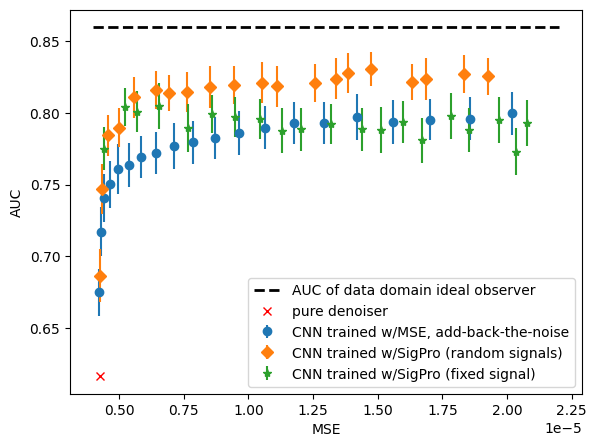

In [23]:
!mkdir final_plots

print(add_back_mse[0], add_back_auc[0])
fig4 = plt.figure()
ax=fig4.add_axes([0.15,0.15,0.8,0.8])

maxaucline = ax.plot([0.4e-5, 2.2e-5], [0.86, 0.86], color='k', linestyle='--', linewidth=2, label='AUC of data domain ideal observer')

e1 = plt.errorbar(add_back_mse[1:],add_back_auc[1:], add_back_std[1:], fmt='o', label='CNN trained w/MSE, add-back-the-noise')
e4 = plt.plot(add_back_mse[0], add_back_auc[0],'rx', label='pure denoiser')

e2 = plt.errorbar(sig_1000_mse, sig_1000_auc, sig_1000_std, fmt='D', label='CNN trained w/SigPro (random signals)')
e3 = plt.errorbar(sig_1_mse, sig_1_auc, sig_1_std, fmt='*', label = 'CNN trained w/SigPro (fixed signal)')

ax.legend(loc='lower right')
ax.set_xlabel('MSE')
ax.set_ylabel('AUC')
plt.show()

fig4.savefig(PATH+'/final_plots/mse_v_auc.pdf')

Run visual comparison figure part 1: identify lambdas and generate/store test images

first identify lambda levels with similar mse for add-back-the-noise, fixed signal retrained CNN, and random signal retrained CNN

In [25]:
print('add back')
print(add_back_mse)
print('fixed signal')
print(sig_1_mse)
print('random signal')
print(sig_1000_mse)


add back
[4.25690277e-06 4.22426651e-06 4.27899480e-06 4.42121707e-06
 4.65073008e-06 4.96704059e-06 5.37140490e-06 5.86264490e-06
 6.44099562e-06 7.10640566e-06 7.86022281e-06 8.70063463e-06
 9.62758821e-06 1.06427274e-05 1.17450658e-05 1.29348776e-05
 1.42110703e-05 1.55759949e-05 1.70273426e-05 1.85654025e-05
 2.01916651e-05]
fixed signal
[4.39558786e-06 5.23247950e-06 5.69351724e-06 6.55615195e-06
 7.66788382e-06 8.58804117e-06 9.46442075e-06 1.04599180e-05
 1.12814716e-05 1.20215519e-05 1.31810656e-05 1.43986537e-05
 1.51351290e-05 1.59716480e-05 1.67061929e-05 1.78477506e-05
 1.85271609e-05 1.96903364e-05 2.03512392e-05 2.07581071e-05]
random signal
[4.24208890e-06 4.33106084e-06 4.56436962e-06 5.00928330e-06
 5.58902306e-06 6.41600305e-06 6.93580664e-06 7.62962847e-06
 8.50060562e-06 9.46037347e-06 1.05057801e-05 1.10925389e-05
 1.25611075e-05 1.33963235e-05 1.38645680e-05 1.47233743e-05
 1.68774521e-05 1.63156667e-05 1.83172380e-05 1.92560000e-05]


low MSE =4.3e-6 --> add_back 2, fixed 0, random 1 //
mid 1 MSE = 5.7e-6 --> add_back 7, fixed 2, random 4 //
mid 2 MSE = 8.5e-5 --> add_back 11, fixed 5, random 8 //
mid 3 MSE = 1e-5 --> add back 13, fixed 7, random 10 //
high MSE = 1.4e-5 --> add back 16, fixed 11, random 14 //

In [26]:
alphavec = np.linspace(0.0,0.2,21, dtype='float32')
net=loadBaseNet()
test_add_back(net,0)
test_add_back(net, alphavec[2])
test_add_back(net, alphavec[7])
test_add_back(net, alphavec[11])
test_add_back(net, alphavec[13])
test_add_back(net, alphavec[16])
test_add_back(net, 0.5)

test denoised MSE: 0.00000426
test denoised AUC: 0.5369
test denoised MSE: 0.00000432
test denoised AUC: 0.6635
test denoised MSE: 0.00000599
test denoised AUC: 0.7576
test denoised MSE: 0.00000889
test denoised AUC: 0.7762
test denoised MSE: 0.00001086
test denoised AUC: 0.7817
test denoised MSE: 0.00001447
test denoised AUC: 0.7883
test denoised MSE: 0.00011004
test denoised AUC: 0.8076


(0.00011003635104134446, 0.807608)

Note: even at alpha = 0.5, the AUC does not exceed the AUC of the fbp.

mkdir: cannot create directory ‘final_plots’: File exists
add_back_alpha_0.019999999552965164
fbp MSE:      0.00043060
denoised MSE: 0.00000866
add_back_alpha_0.07000000029802322
fbp MSE:      0.00043060
denoised MSE: 0.00000997
add_back_alpha_0.10999999940395355
fbp MSE:      0.00043060
denoised MSE: 0.00001259
add_back_alpha_0.1599999964237213
fbp MSE:      0.00043060
denoised MSE: 0.00001781
random signals lambda = 0.002:
fbp MSE:      0.00043060
denoised MSE: 0.00000840
test denoised MSE: 0.00000433
test denoised AUC: 0.7323
random signals lambda = 0.005:
fbp MSE:      0.00043060
denoised MSE: 0.00000923
test denoised MSE: 0.00000558
test denoised AUC: 0.7825
random signals lambda = 0.009000000000000001:
fbp MSE:      0.00043060
denoised MSE: 0.00001154
test denoised MSE: 0.00000850
test denoised AUC: 0.7917
random signals lambda = 0.015:
fbp MSE:      0.00043060
denoised MSE: 0.00001653
test denoised MSE: 0.00001385
test denoised AUC: 0.7988
fixed signals lambda = 0.001:
fbp MSE: 

(7.671222279213907e-06, 0.781028)

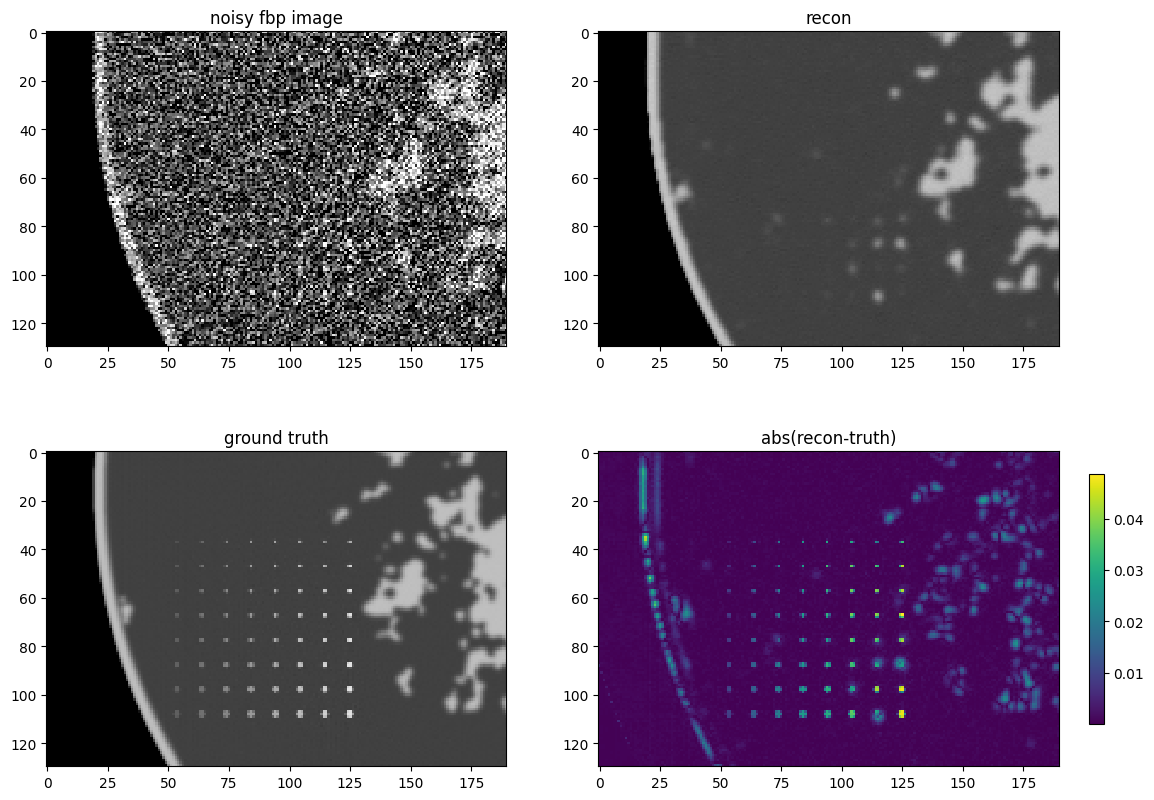

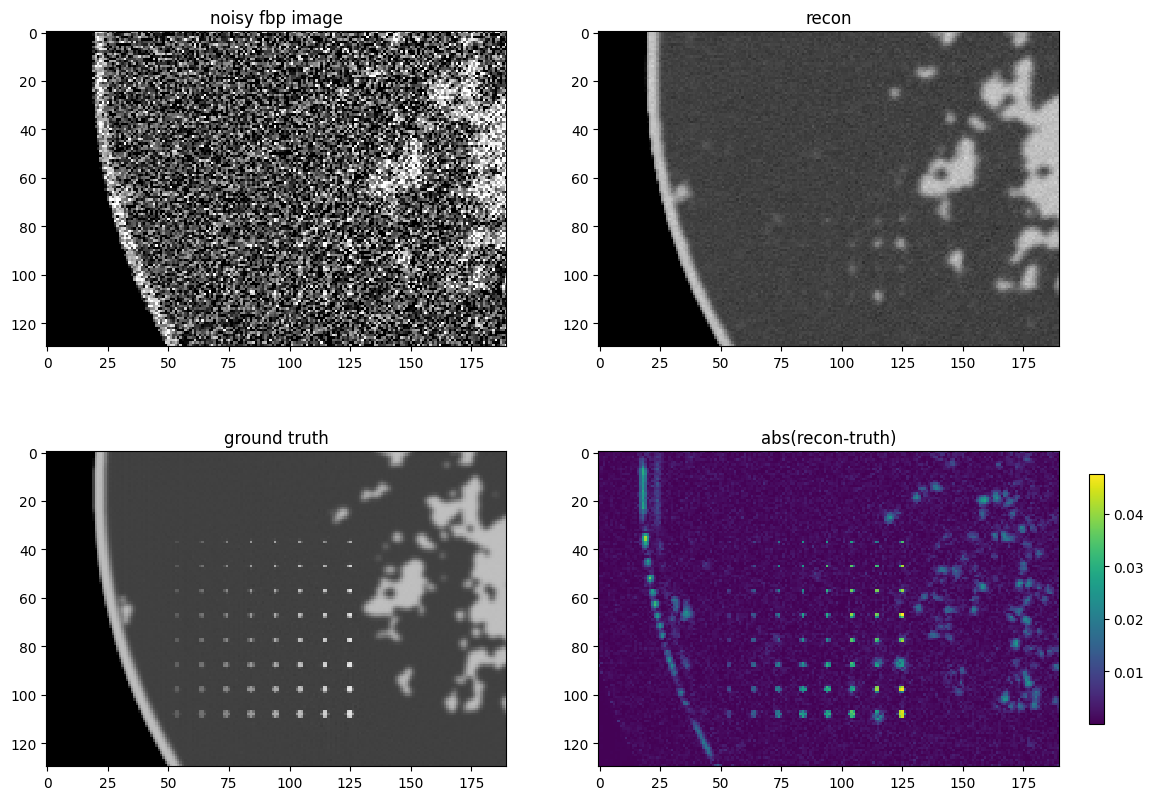

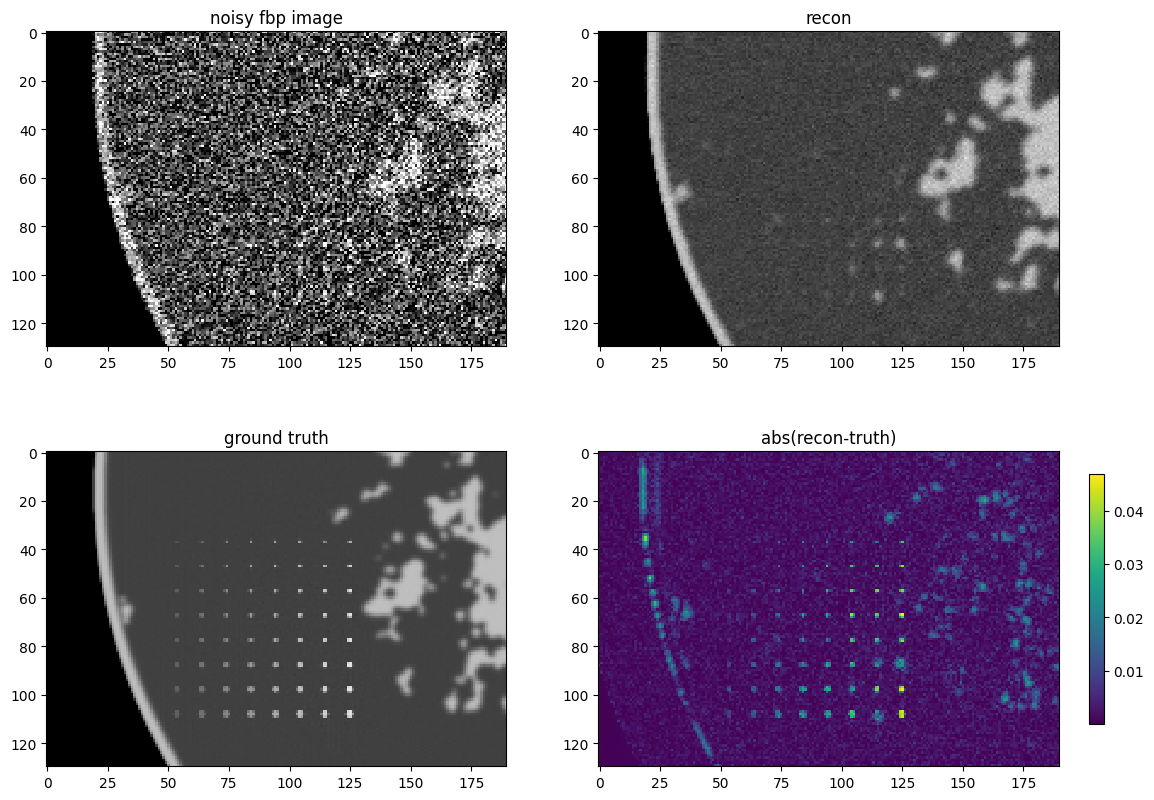

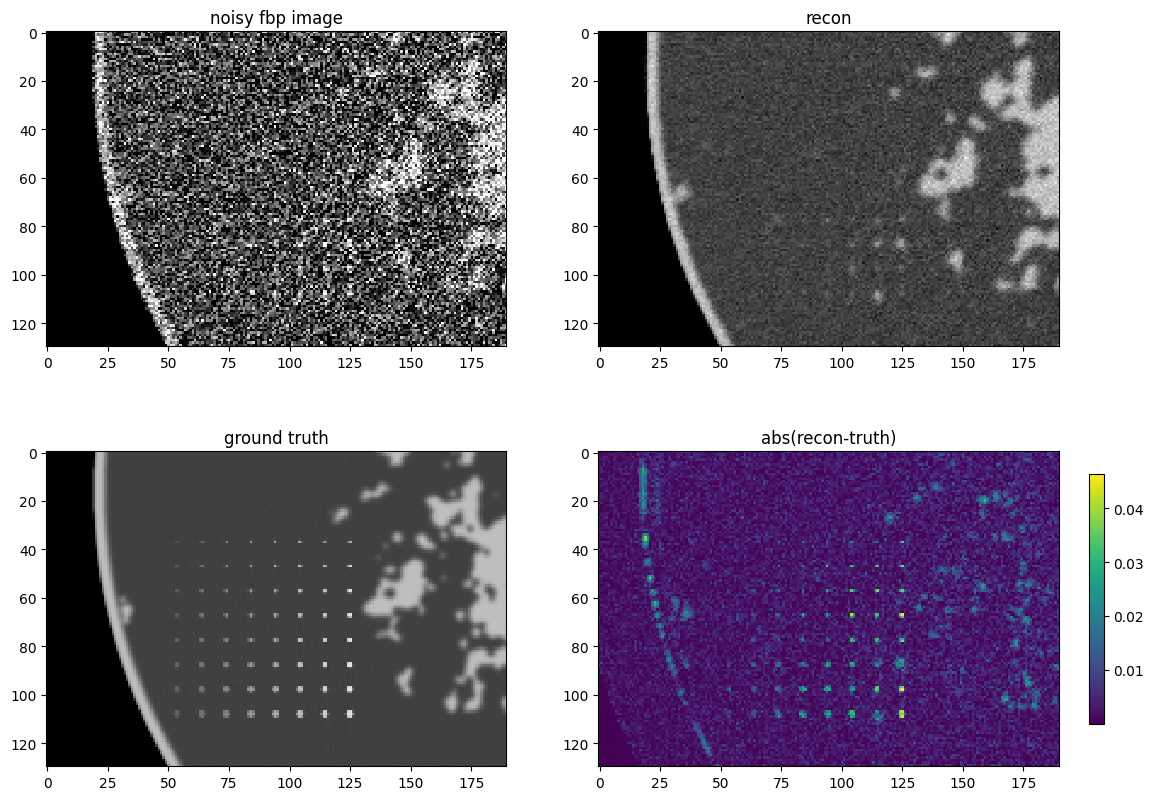

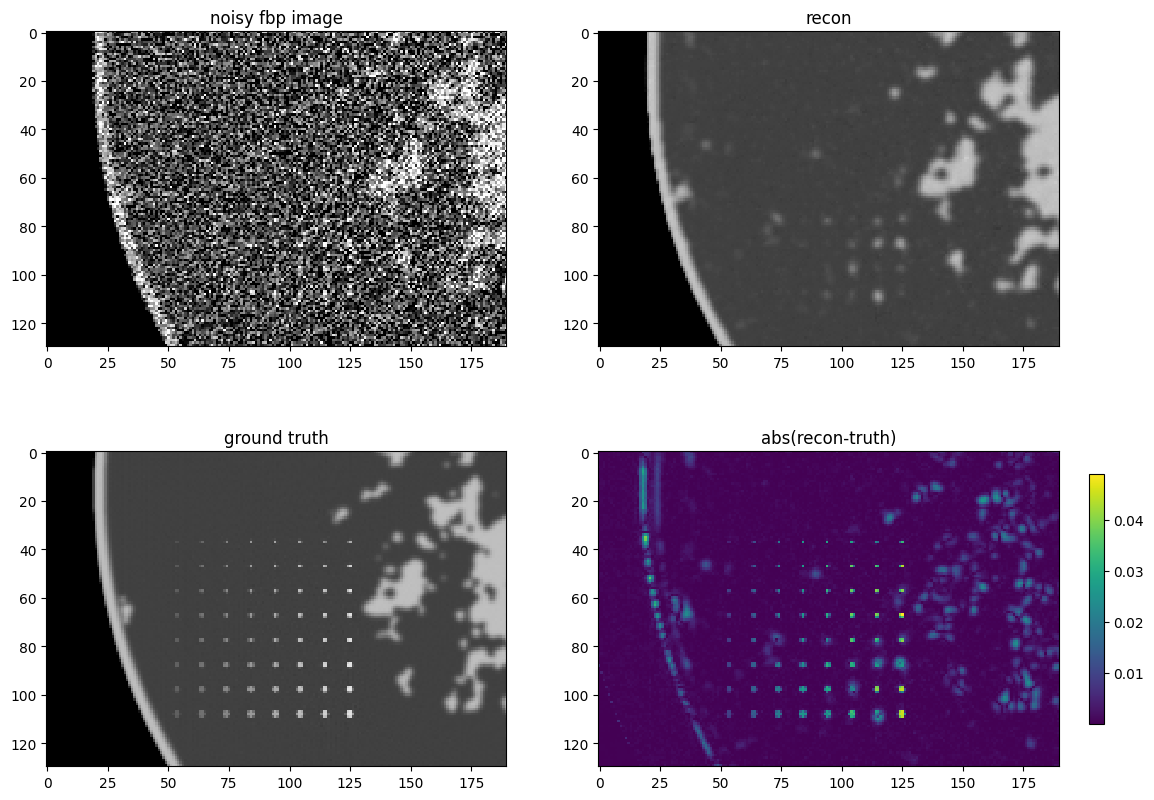

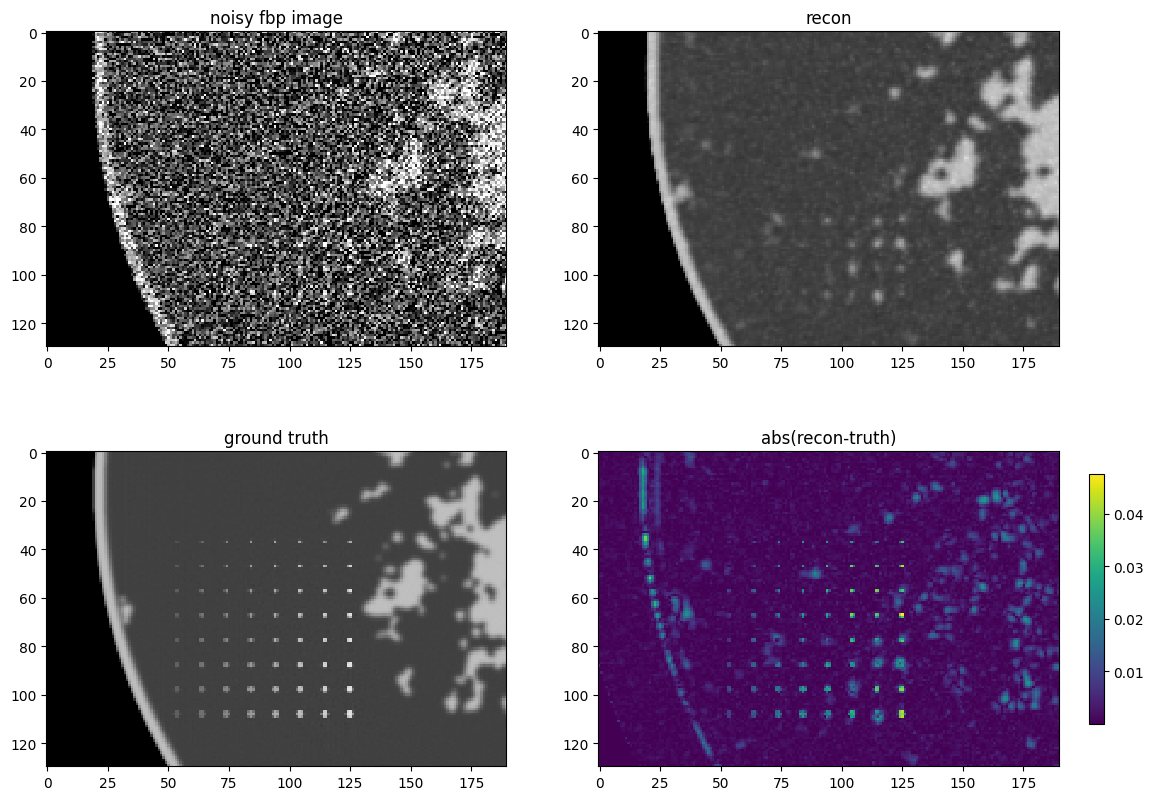

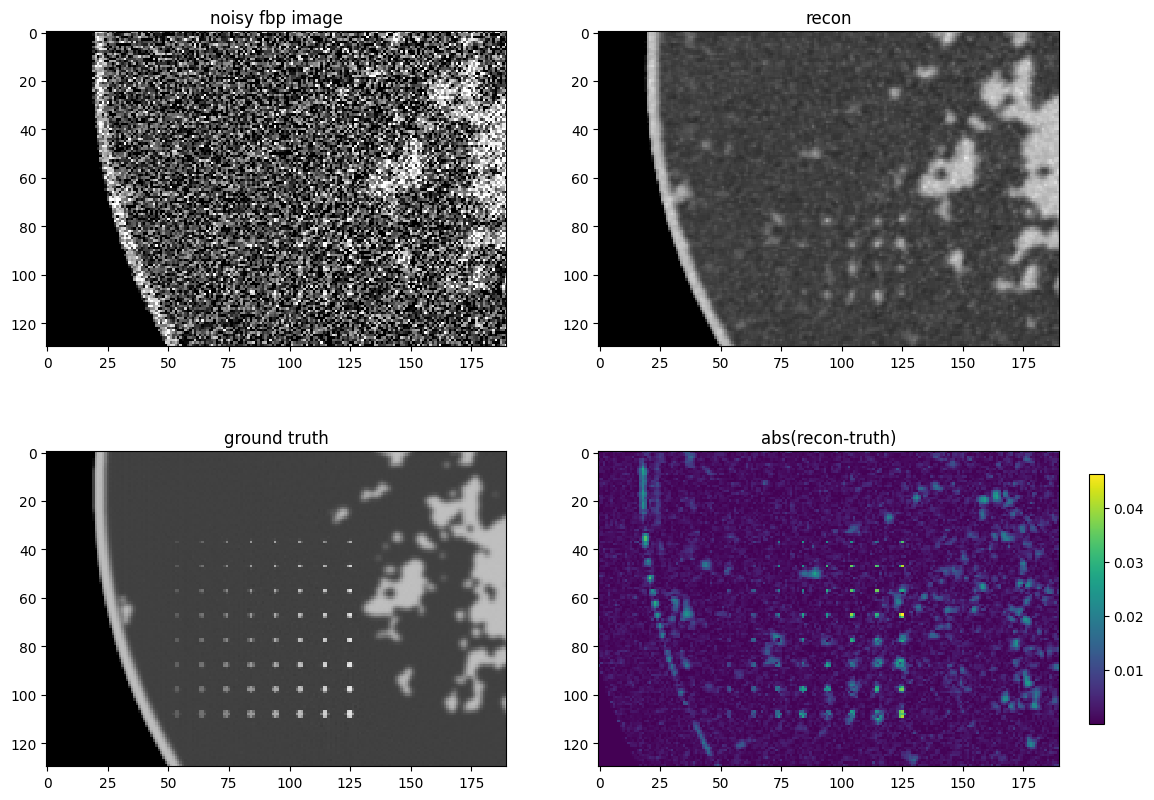

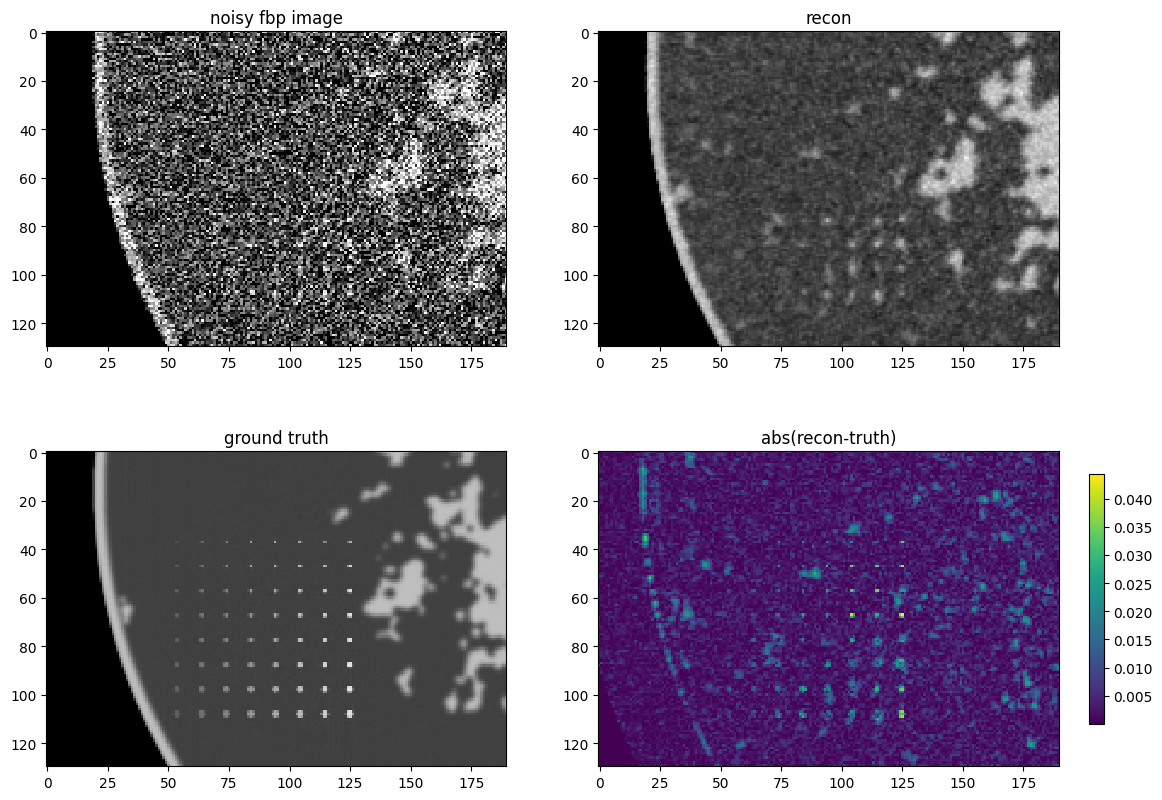

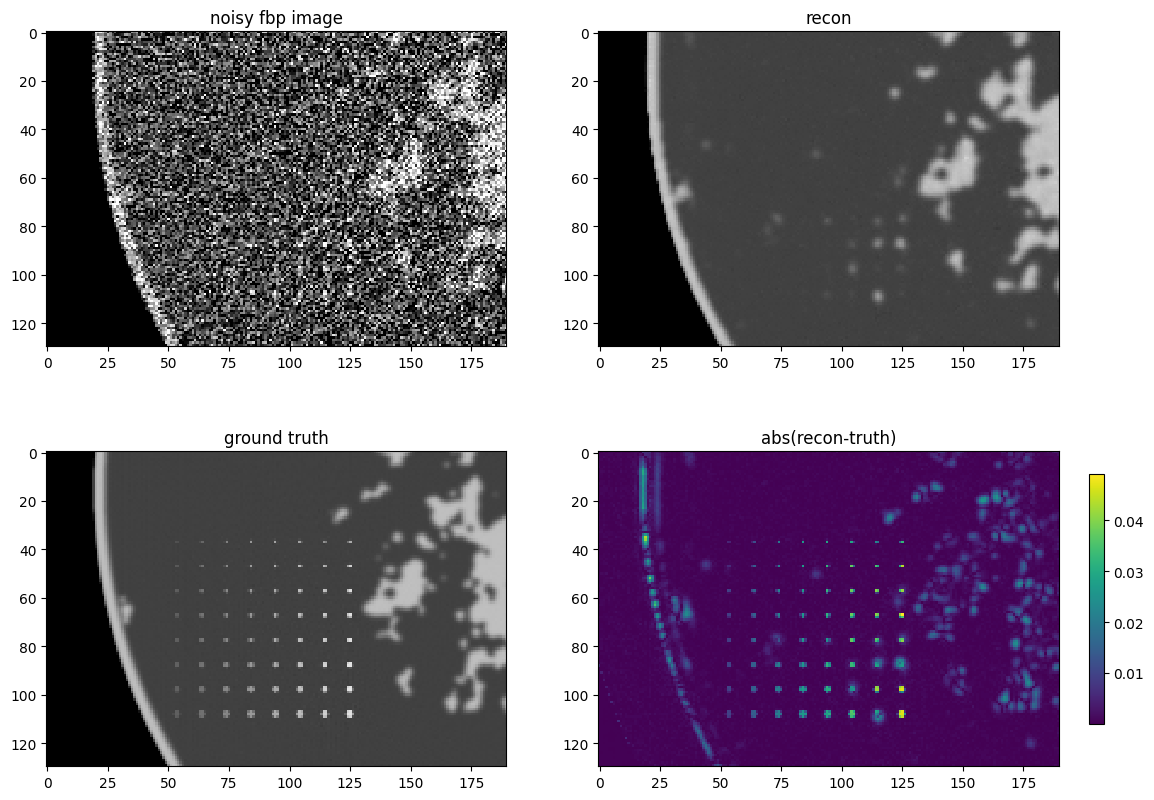

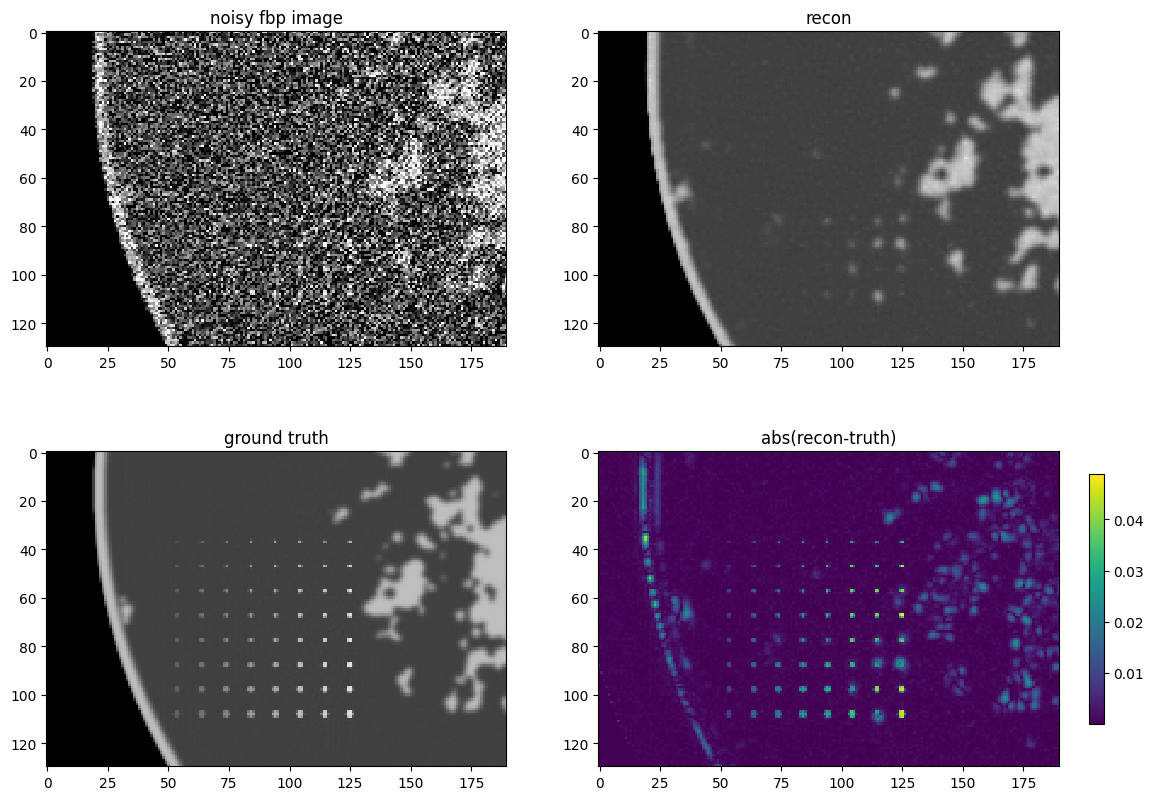

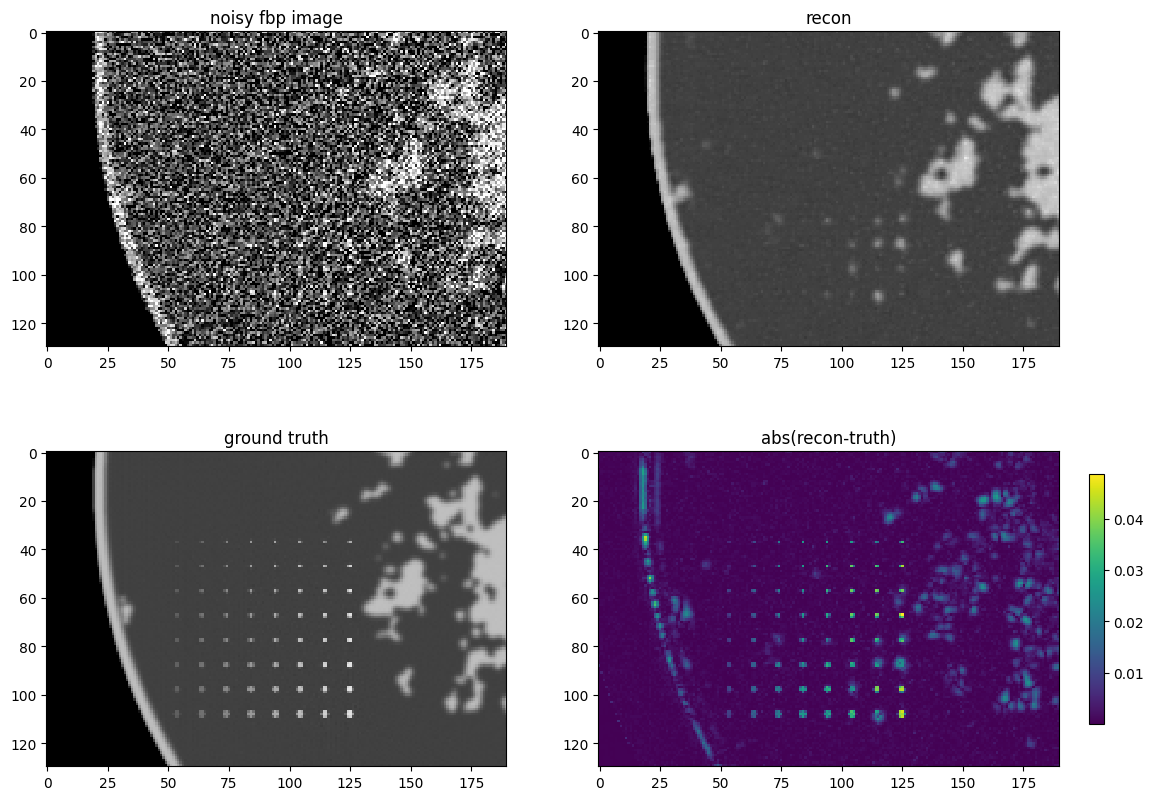

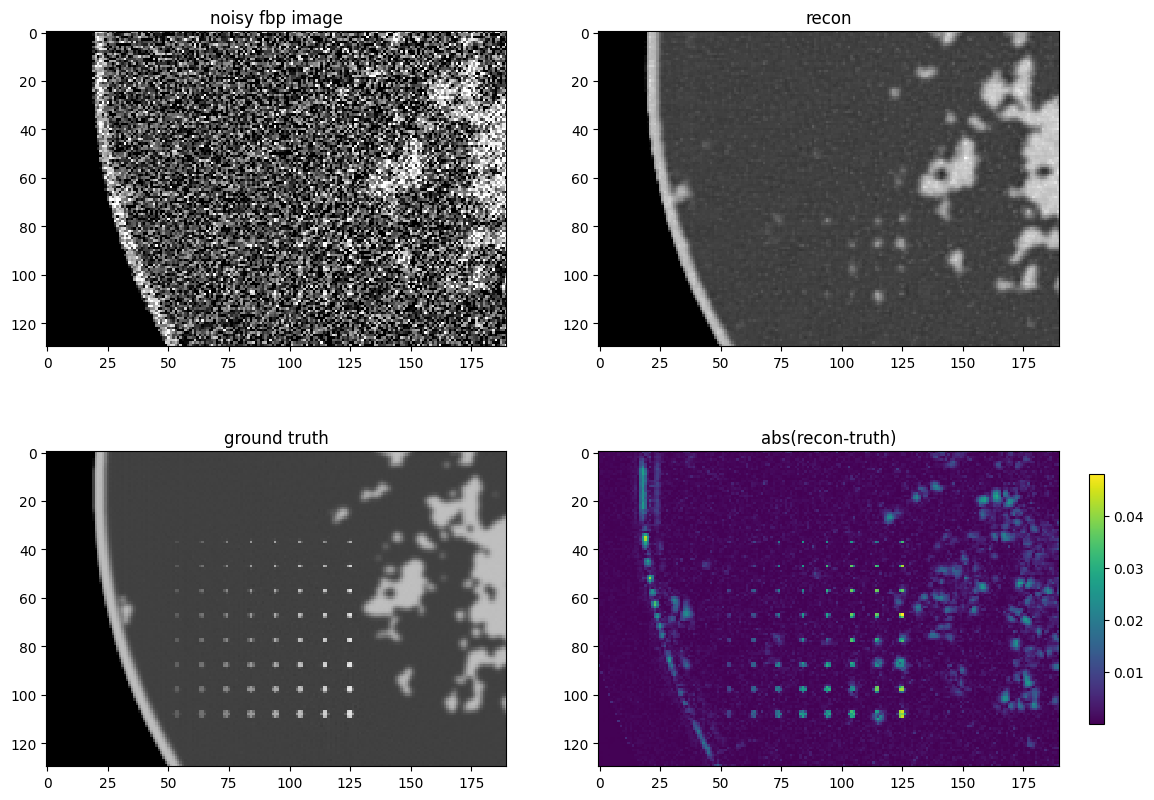

In [ ]:
!mkdir final_plots

#MODELDIR = "/models/" #use this if reproducing results
MODELDIR = "/data/saved_models/"  #use this if wanting to load pre-trained nets

#generate and store images for each model at the specified lambda level
lambda_set = np.linspace(1e-3,2e-2,20)
alphavec = np.linspace(0.0,0.2,21, dtype='float32')
#add-back model
temp_net=loadBaseNet()
print(f'add_back_alpha_{alphavec[2]}')
denoise_single_test_add_back(temp_net, alphavec[2], True, True, PATH+'/final_plots/add_back_DEMO_LOWEST_MSE.npy')
print(f'add_back_alpha_{alphavec[7]}')
denoise_single_test_add_back(temp_net, alphavec[7], True, True, PATH+'/final_plots/add_back_DEMO_MID1_MSE.npy')
print(f'add_back_alpha_{alphavec[11]}')
denoise_single_test_add_back(temp_net, alphavec[11],True, True, PATH+'/final_plots/add_back_DEMO_MID2_MSE.npy')
print(f'add_back_alpha_{alphavec[16]}')
denoise_single_test_add_back(temp_net, alphavec[16], True, True, PATH+'/final_plots/add_back_DEMO_HIGH_MSE.npy')


temp_net=loadBaseNet()
print(f'random signals lambda = {lambda_set[1]}:')
f_name=f"sig_1000_lam_{lambda_set[1]}_"
trained_weights=torch.load(PATH+MODELDIR+f_name+"dict.pth",map_location=torch.device(device))
temp_net.load_state_dict(trained_weights)
denoise_single_test(temp_net, True, True, PATH+'/final_plots/RANDOM_SIG_DEMO_LOWEST_MSE.npy')
test_net(temp_net)

temp_net=loadBaseNet()
print(f'random signals lambda = {lambda_set[4]}:')
f_name=f"sig_1000_lam_{lambda_set[4]}_"
trained_weights=torch.load(PATH+MODELDIR+f_name+"dict.pth",map_location=torch.device(device))
temp_net.load_state_dict(trained_weights)
denoise_single_test(temp_net, True, True, PATH+'/final_plots/RANDOM_SIG_DEMO_MID1_MSE.npy')
test_net(temp_net)

temp_net=loadBaseNet()
print(f'random signals lambda = {lambda_set[8]}:')
f_name=f"sig_1000_lam_{lambda_set[8]}_"
trained_weights=torch.load(PATH+MODELDIR+f_name+"dict.pth",map_location=torch.device(device))
temp_net.load_state_dict(trained_weights)
denoise_single_test(temp_net, True, True, PATH+'/final_plots/RANDOM_SIG_DEMO_MID2_MSE.npy')
test_net(temp_net)

temp_net=loadBaseNet()
print(f'random signals lambda = {lambda_set[14]}:')
f_name=f"sig_1000_lam_{lambda_set[14]}_"
trained_weights=torch.load(PATH+MODELDIR+f_name+"dict.pth",map_location=torch.device(device))
temp_net.load_state_dict(trained_weights)
denoise_single_test(temp_net, True, True, PATH+'/final_plots/RANDOM_SIG_DEMO_HIGH_MSE.npy')
test_net(temp_net)

temp_net=loadBaseNet()
print(f'fixed signals lambda = {lambda_set[0]}:')
f_name=f"sig_1_lam_{lambda_set[0]}_"
trained_weights=torch.load(PATH+MODELDIR+f_name+"dict.pth",map_location=torch.device(device))
temp_net.load_state_dict(trained_weights)
denoise_single_test(temp_net, True, True, PATH+'/final_plots/FIXED_SIG_DEMO_LOWEST_MSE.npy')
test_net(temp_net)

temp_net=loadBaseNet()
print(f'fixed signals lambda = {lambda_set[1]}:')
f_name=f"sig_1_lam_{lambda_set[1]}_"
trained_weights=torch.load(PATH+MODELDIR+f_name+"dict.pth",map_location=torch.device(device))
temp_net.load_state_dict(trained_weights)
denoise_single_test(temp_net, True, True, PATH+'/final_plots/FIXED_SIG_DEMO_MID1_MSE.npy')
test_net(temp_net)

temp_net=loadBaseNet()
print(f'fixed signals lambda = {lambda_set[2]}:')
f_name=f"sig_1_lam_{lambda_set[2]}_"
trained_weights=torch.load(PATH+MODELDIR+f_name+"dict.pth",map_location=torch.device(device))
temp_net.load_state_dict(trained_weights)
denoise_single_test(temp_net, True, True, PATH+'/final_plots/FIXED_SIG_DEMO_MID2_MSE.npy')
test_net(temp_net)

temp_net=loadBaseNet()
print(f'fixed signals lambda = {lambda_set[4]}:')
f_name=f"sig_1_lam_{lambda_set[4]}_"
trained_weights=torch.load(PATH+MODELDIR+f_name+"dict.pth",map_location=torch.device(device))
temp_net.load_state_dict(trained_weights)
denoise_single_test(temp_net, True, True, PATH+'/final_plots/FIXED_SIG_DEMO_HIGH_MSE.npy')
test_net(temp_net)

Run visual comparison figure part 2: combine test images into single plot

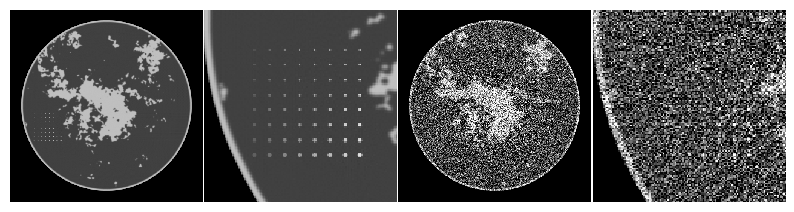

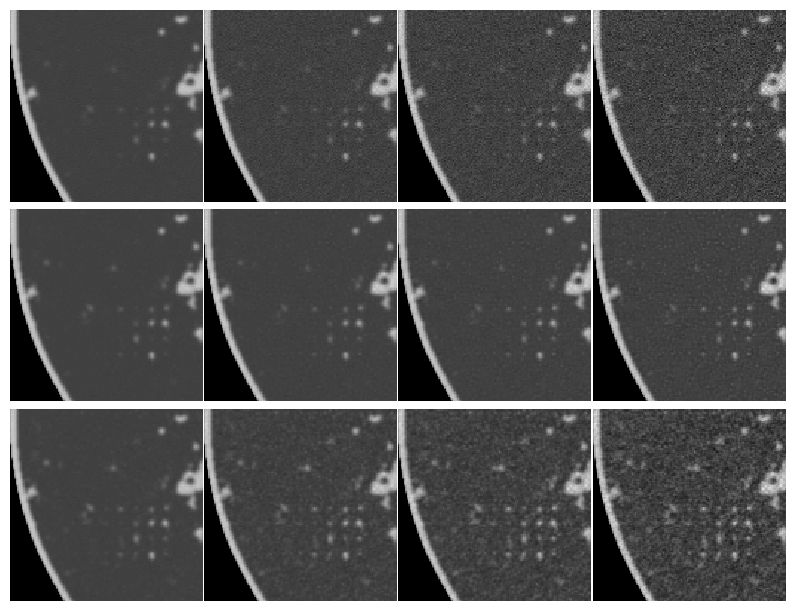

In [16]:
DATADIR = "/data/singledata512smoothObj_nph4e10/"

noisy_image = np.load(PATH+DATADIR+"fbp_128view_noisy.npy")
truth_image  = np.load(PATH+DATADIR+"fbp_1024view_noiseless.npy")
denoised_image0 = np.load(PATH+"/final_plots/FIXED_SIG_DEMO_LOWEST_MSE.npy")
denoised_image1 = np.load(PATH+"/final_plots/FIXED_SIG_DEMO_MID1_MSE.npy")
denoised_image2 = np.load(PATH+"/final_plots/FIXED_SIG_DEMO_MID2_MSE.npy")
denoised_image3 = np.load(PATH+"/final_plots/FIXED_SIG_DEMO_HIGH_MSE.npy")

denoised_image4 = np.load(PATH+"/final_plots/RANDOM_SIG_DEMO_LOWEST_MSE.npy")
denoised_image5 = np.load(PATH+"/final_plots/RANDOM_SIG_DEMO_MID1_MSE.npy")
denoised_image6 = np.load(PATH+"/final_plots/RANDOM_SIG_DEMO_MID2_MSE.npy")
denoised_image7 = np.load(PATH+"/final_plots/RANDOM_SIG_DEMO_HIGH_MSE.npy")

denoised_image8 = np.load(PATH+"/final_plots/add_back_DEMO_LOWEST_MSE.npy")
denoised_image9 = np.load(PATH+"/final_plots/add_back_DEMO_MID1_MSE.npy")
denoised_image10 = np.load(PATH+"/final_plots/add_back_DEMO_MID2_MSE.npy")
denoised_image11 = np.load(PATH+"/final_plots/add_back_DEMO_HIGH_MSE.npy")

mask = np.zeros_like(noisy_image).astype('bool')
mask[250:380,30:160] = True

truth_image_clip = truth_image[mask].reshape((130,130))
noisy_image_clip = noisy_image[mask].reshape((130,130))
denoised_image0_clip = denoised_image0[mask].reshape((130,130))
denoised_image1_clip = denoised_image1[mask].reshape((130,130))
denoised_image2_clip = denoised_image2[mask].reshape((130,130))
denoised_image3_clip = denoised_image3[mask].reshape((130,130))

denoised_image4_clip = denoised_image4[mask].reshape((130,130))
denoised_image5_clip = denoised_image5[mask].reshape((130,130))
denoised_image6_clip = denoised_image6[mask].reshape((130,130))
denoised_image7_clip = denoised_image7[mask].reshape((130,130))

denoised_image8_clip = denoised_image8[mask].reshape((130,130))
denoised_image9_clip = denoised_image9[mask].reshape((130,130))
denoised_image10_clip = denoised_image10[mask].reshape((130,130))
denoised_image11_clip = denoised_image11[mask].reshape((130,130))


alpha = 0.0
fig, ax = plt.subplots(1, 4, figsize=(10,10))

lim = [0.174, 0.253]

ax[0].imshow(truth_image,vmin=lim[0],vmax=lim[1], interpolation='nearest', cmap='gray')
#ax[0].set_title('Clean Image')
ax[1].imshow(truth_image_clip, vmin=lim[0],vmax=lim[1], interpolation='nearest', cmap='gray')
#ax[1].set_title('Clean Image Zoom')
#ax[2].set_title('Noisy FBP Image')
ax[2].imshow(noisy_image,vmin=lim[0],vmax=lim[1], interpolation='nearest', cmap='gray')
#ax[3].set_title('Noisy FBP Image Zoom')
ax[3].imshow(noisy_image_clip, vmin=lim[0],vmax=lim[1], interpolation='nearest', cmap='gray')

for a in ax.flatten():  # turns off axes
  a.axis("off")
  a.axis("tight")  # gets rid of white border
  a.axis("image")  # square up the image instead of filling the "figure" space
# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.82, 0.17, 0.01, 0.25])
# fig.colorbar(im, cax=cbar_ax)
fig.subplots_adjust(wspace=0.01, hspace=0.01)
plt.savefig(PATH+'/final_plots/noisy_clean_clips.pdf')
plt.show()

fig, ax = plt.subplots(3, 4, figsize=(10,8))

ax[0,0].imshow(denoised_image8_clip,vmin=lim[0],vmax=lim[1], interpolation='nearest', cmap='gray')
#ax[0,0].set_title('Low lambda',wrap=True)
ax[0,1].imshow(denoised_image9_clip, vmin=lim[0],vmax=lim[1], interpolation='nearest', cmap='gray')
#ax[0,1].set_title('IDEAL lambda',wrap=True)
ax[0,2].imshow(denoised_image10_clip, vmin=lim[0],vmax=lim[1], interpolation='nearest', cmap='gray')
#ax[0,2].set_title('Mid lambda',wrap=True)
ax[0,3].imshow(denoised_image11_clip, vmin=lim[0],vmax=lim[1], interpolation='nearest', cmap='gray')
#ax[0,3].set_title('High lamda',wrap=True)

#ax[1,0].set_title('Random Signal ObsLoss Retrained Network')
ax[1,0].imshow(denoised_image0_clip,vmin=lim[0],vmax=lim[1], interpolation='nearest', cmap='gray')
#ax[2,0].set_title('Low lamda',wrap=True)
ax[1,1].imshow(denoised_image1_clip, vmin=lim[0],vmax=lim[1], interpolation='nearest', cmap='gray')
#ax[2,1].set_title('IDEAL lambda',wrap=True)
ax[1,2].imshow(denoised_image2_clip, vmin=lim[0],vmax=lim[1], interpolation='nearest', cmap='gray')
#ax[2,2].set_title('Mid MSE',wrap=True)
ax[1,3].imshow(denoised_image3_clip, vmin=lim[0],vmax=lim[1], interpolation='nearest', cmap='gray')
#ax[2,3].set_title('High MSE',wrap=True)


#ax[2,0].set_title('Fixed Signal ObsLoss Retrained Network')
ax[2,0].imshow(denoised_image4_clip,vmin=lim[0],vmax=lim[1], interpolation='nearest', cmap='gray')
#ax[3,0].set_title('Low MSE',wrap=True)
ax[2,1].imshow(denoised_image5_clip, vmin=lim[0],vmax=lim[1], interpolation='nearest', cmap='gray')
#ax[3,1].set_title('IDEAL',wrap=True)
ax[2,2].imshow(denoised_image6_clip, vmin=lim[0],vmax=lim[1], interpolation='nearest', cmap='gray')
#ax[3,2].set_title('Mid MSE',wrap=True)
ax[2,3].imshow(denoised_image7_clip, vmin=lim[0],vmax=lim[1], interpolation='nearest', cmap='gray')
#ax[3,3].set_title('High MSE',wrap=True)


for a in ax.flatten():  # turns off axes
  a.axis("off")
  a.axis("tight")  # gets rid of white border
  a.axis("image")  # square up the image instead of filling the "figure" space
# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.82, 0.17, 0.01, 0.25])
# fig.colorbar(im, cax=cbar_ax)
fig.subplots_adjust(wspace=0.01, hspace=-0.08)
plt.savefig(PATH+'/final_plots/demo_images.pdf')

run laplacian testing figures

add back ideal alpha = 0.029999999329447746
fixed signal obs reg ideal lambda = 0.007
random signal obs reg ideal lamda = 0.005


<ipython-input-21-47fe4798333a>:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


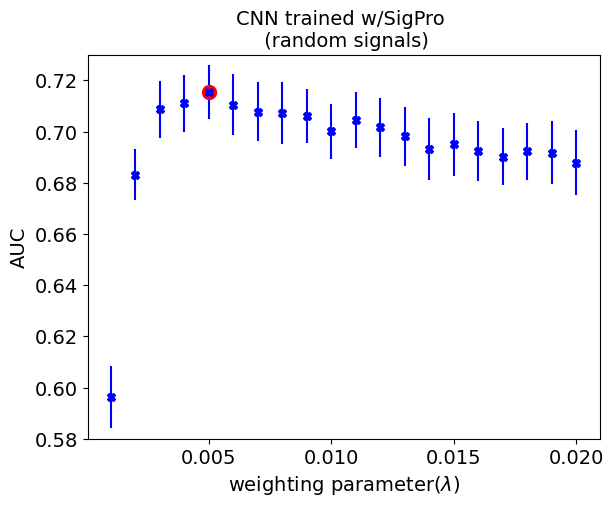

<ipython-input-21-47fe4798333a>:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


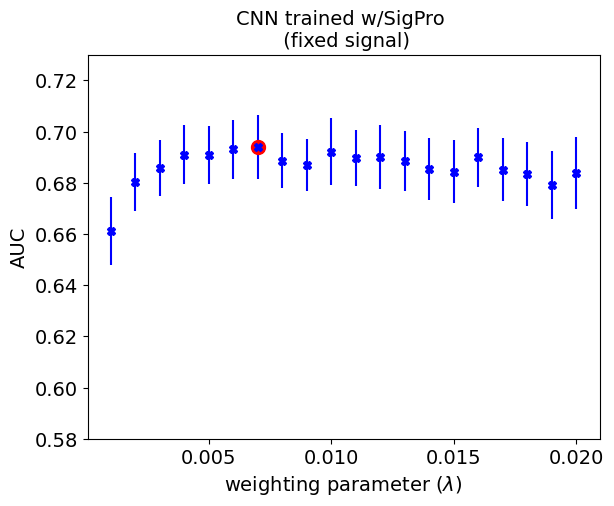

<ipython-input-21-47fe4798333a>:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


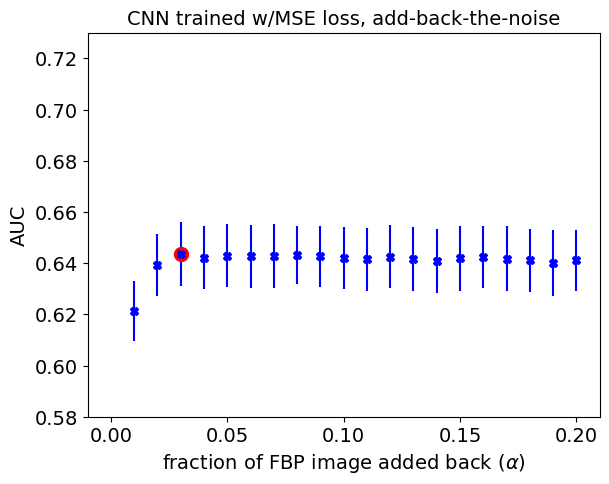

In [21]:
lambda_set = np.linspace(1e-3,2e-2,20)
alphavec = np.linspace(0.0,0.2,21, dtype='float32')

print(f'add back ideal alpha = {alphavec[3]}')
print(f'fixed signal obs reg ideal lambda = {lambda_set[6]}')
print(f'random signal obs reg ideal lamda = {lambda_set[4]}')

fig1 = plt.figure()
ax=fig1.add_axes([0.2,0.2,0.8,0.8])
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
e1 = plt.errorbar(lambda_set, lap_sig_1000_auc, lap_sig_1000_std, fmt='bX')
plt.plot(lambda_set[4], lap_sig_1000_auc[4],'or',markersize=10)
ax.set_xlabel(r'weighting parameter($\lambda$)', fontsize=14)
ax.set_ylabel('AUC', fontsize=14)
ax.set_title('CNN trained w/SigPro \n (random signals)', fontsize=14)
ax.set_ylim([0.58,0.73])
plt.tight_layout()
plt.savefig(PATH+'/final_plots/lap_lambda_AUC_random.pdf',bbox_inches='tight')
plt.show()


fig3 = plt.figure()
ax=fig3.add_axes([0.2,0.2,0.8,0.8])
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
e1 = plt.errorbar(lambda_set, lap_sig_1_auc, lap_sig_1_std, fmt='bX')
plt.plot(lambda_set[6], lap_sig_1_auc[6],'or',markersize=10)
ax.set_xlabel(r'weighting parameter ($\lambda$)', fontsize=14)
ax.set_ylabel('AUC', fontsize=14)
ax.set_title('CNN trained w/SigPro \n (fixed signal)', fontsize=14)
ax.set_ylim([0.58,0.73])
plt.tight_layout()
plt.savefig(PATH+'/final_plots/lap_lambda_AUC_fixed.pdf',bbox_inches='tight')
plt.show()


#ADD BACK PLOTS
fig5 = plt.figure()
ax=fig5.add_axes([0.2,0.2,0.8,0.8])
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
e1 = plt.errorbar(alphavec, lap_add_back_auc, lap_add_back_std, fmt='bX')
plt.plot(alphavec[3], lap_add_back_auc[3],'or',markersize=10)
ax.set_xlabel(r'fraction of FBP image added back ($\alpha$)', fontsize=14) #use alpha symbol?
ax.set_ylabel('AUC', fontsize=14)
ax.set_title('CNN trained w/MSE loss, add-back-the-noise', fontsize=14)
ax.set_ylim([0.58,0.73])
plt.tight_layout()
plt.savefig(PATH+'/final_plots/lap_lambda_AUC_add_back.pdf',bbox_inches='tight')
plt.show()


reconstructed images at ideal lambdas based on laplacian testing

add_back_alpha_0.029999999329447746
fbp MSE:      0.00043060
denoised MSE: 0.00000874
test denoised MSE: 0.00000448
test denoised AUC: 0.6997
fixed signals lambda = 0.007:
fbp MSE:      0.00043060
denoised MSE: 0.00001466
test denoised MSE: 0.00000945
test denoised AUC: 0.7903
random signals lambda = 0.005:
fbp MSE:      0.00043060
denoised MSE: 0.00000923
test denoised MSE: 0.00000558
test denoised AUC: 0.7825


(5.582558579135366e-06, 0.782468)

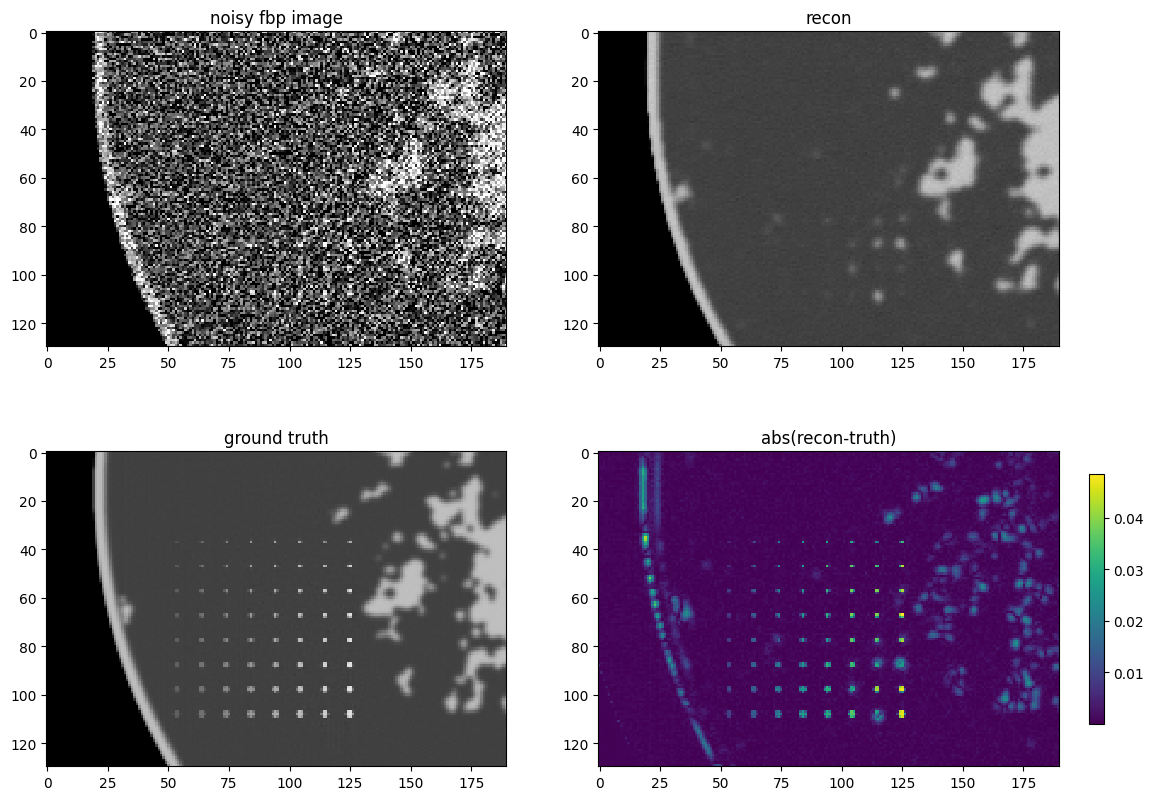

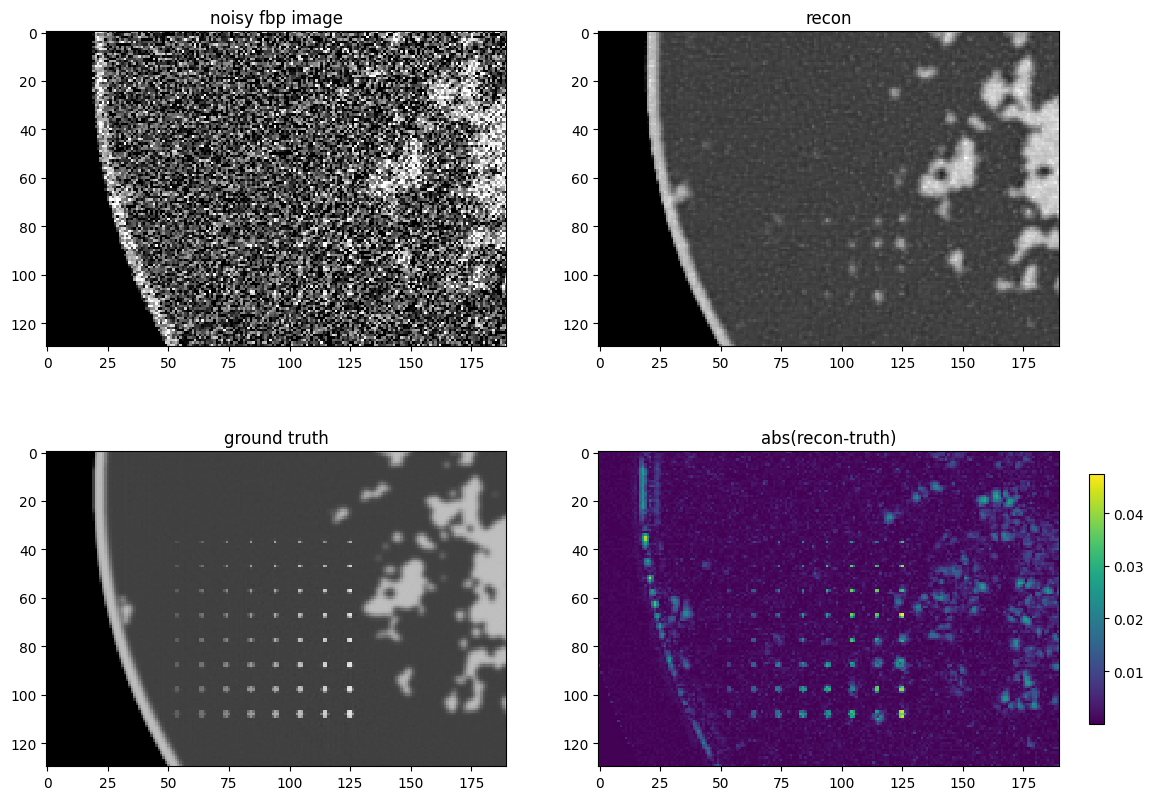

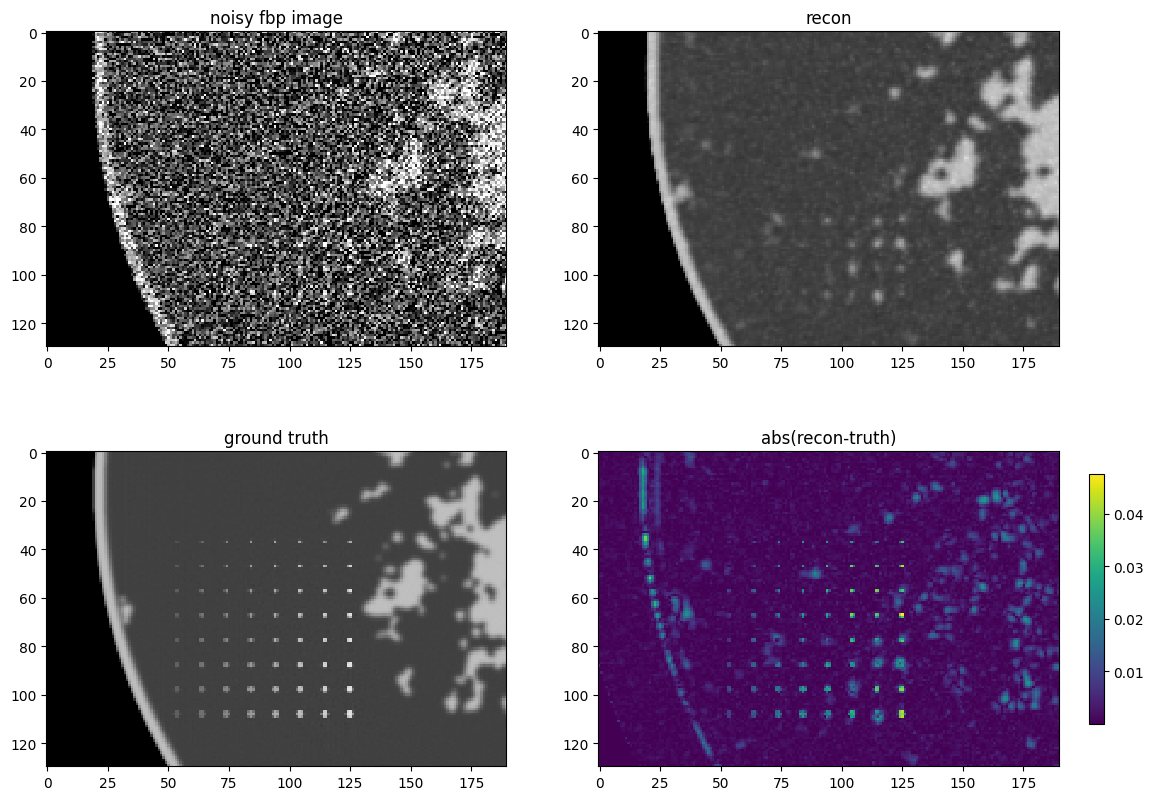

In [18]:
alphavec = np.linspace(0.0,0.2,21, dtype='float32')
print(f'add_back_alpha_{alphavec[3]}')
temp_net=loadBaseNet()
denoise_single_test_add_back(temp_net, alphavec[3], True, True, PATH+'/final_plots/add_back_DEMO_IDEAL_MSE.npy')
test_add_back(temp_net, alphavec[3])

temp_net=loadBaseNet()
print(f'fixed signals lambda = {lambda_set[6]}:')
f_name=f"sig_1_lam_{lambda_set[6]}_"
trained_weights=torch.load(PATH+MODELDIR+f_name+"dict.pth",map_location=torch.device(device))
temp_net.load_state_dict(trained_weights)
denoise_single_test(temp_net, True, True, PATH+'/final_plots/FIXED_SIG_DEMO_IDEAL_MSE.npy')
test_net(temp_net)

temp_net=loadBaseNet()
print(f'random signals lambda = {lambda_set[4]}:')
f_name=f"sig_1000_lam_{lambda_set[4]}_"
trained_weights=torch.load(PATH+MODELDIR+f_name+"dict.pth",map_location=torch.device(device))
temp_net.load_state_dict(trained_weights)
denoise_single_test(temp_net, True, True, PATH+'/final_plots/RANDOM_SIG_DEMO_IDEAL_MSE.npy')
test_net(temp_net)

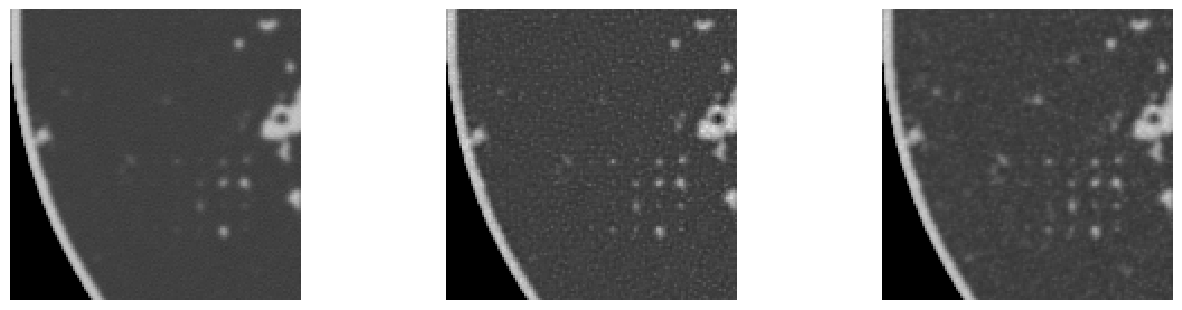

In [22]:
DATADIR = "/data/singledata512smoothObj_nph4e10/"

noisy_image = np.load(PATH+DATADIR+"fbp_128view_noisy.npy")
truth_image  = np.load(PATH+DATADIR+"fbp_1024view_noiseless.npy")
denoised_image0 = np.load(PATH+"/final_plots/add_back_DEMO_IDEAL_MSE.npy")
denoised_image1 = np.load(PATH+"/final_plots/FIXED_SIG_DEMO_IDEAL_MSE.npy")
denoised_image2 = np.load(PATH+"/final_plots/RANDOM_SIG_DEMO_IDEAL_MSE.npy")


mask = np.zeros_like(noisy_image).astype('bool')
mask[250:380,30:160] = True

denoised_image0_clip = denoised_image0[mask].reshape((130,130))
denoised_image1_clip = denoised_image1[mask].reshape((130,130))
denoised_image2_clip = denoised_image2[mask].reshape((130,130))


alpha = 0.0
fig, ax = plt.subplots(1, 3, figsize=(15,15))

lim = [0.174, 0.253]

ax[0].imshow(denoised_image0_clip,vmin=lim[0],vmax=lim[1], interpolation='nearest', cmap='gray')
ax[1].imshow(denoised_image1_clip, vmin=lim[0],vmax=lim[1], interpolation='nearest', cmap='gray')
ax[2].imshow(denoised_image2_clip,vmin=lim[0],vmax=lim[1], interpolation='nearest', cmap='gray')


for a in ax.flatten():  # turns off axes
  a.axis("off")
  a.axis("image")  # square up the image instead of filling the "figure" space
fig.subplots_adjust(wspace=0.5, hspace=0.01)
plt.savefig(PATH+'/final_plots/ideal_clips.pdf')
plt.show()